<a href="https://colab.research.google.com/github/m677s345/EECS_731_SEMESTER_PROJECT_TRENDING/blob/main/EECS_731__Semester_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install cookiecutter
!cookiecutter https://github.com/drivendata/cookiecutter-data-science

You've downloaded /root/.cookiecutters/cookiecutter-data-science before. Is it okay to delete and re-download it? [yes]: n
Do you want to re-use the existing version? [yes]: y
project_name [project_name]: 
repo_name [project_name]: 
author_name [Your name (or your organization/company/team)]: 
description [A short description of the project.]: 


Select open_source_license:
1 - MIT
2 - BSD-3-Clause
3 - No license file
Choose from 1, 2, 3 [1]: s3_bucket [[OPTIONAL] your-bucket-for-syncing-data (do not include 's3://')]: aws_profile [default]: 
Select python_interpreter:
1 - python3
2 - python
Choose from 1, 2 [1]: 
Error: "project_name" directory already exists


# Packages and Data Cleaning 

In [1]:
# libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib import rcParams
import collections
import os
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS
import string
import re 
import nltk
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.holtwinters import ExponentialSmoothing
%matplotlib inline
plt.style.use('fivethirtyeight')
from pylab import rcParams

In [2]:
df = pd.read_csv("/content/project_name/data/raw/US_youtube_trending_data.csv",header=0)

In [3]:
df.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11T19:20:14Z,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12T00:00:00Z,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313,https://i.ytimg.com/vi/3C66w5Z0ixs/default.jpg,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...
1,M9Pmf9AB4Mo,Apex Legends | Stories from the Outlands – “Th...,2020-08-11T17:00:10Z,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2020-08-12T00:00:00Z,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,2794,16549,https://i.ytimg.com/vi/M9Pmf9AB4Mo/default.jpg,False,False,"While running her own modding shop, Ramya Pare..."
2,J78aPJ3VyNs,I left youtube for a month and THIS is what ha...,2020-08-11T16:34:06Z,UCYzPXprvl5Y-Sf0g4vX-m6g,jacksepticeye,24,2020-08-12T00:00:00Z,jacksepticeye|funny|funny meme|memes|jacksepti...,2038853,353787,2628,40221,https://i.ytimg.com/vi/J78aPJ3VyNs/default.jpg,False,False,I left youtube for a month and this is what ha...
3,kXLn3HkpjaA,XXL 2020 Freshman Class Revealed - Official An...,2020-08-11T16:38:55Z,UCbg_UMjlHJg_19SZckaKajg,XXL,10,2020-08-12T00:00:00Z,xxl freshman|xxl freshmen|2020 xxl freshman|20...,496771,23251,1856,7647,https://i.ytimg.com/vi/kXLn3HkpjaA/default.jpg,False,False,Subscribe to XXL → http://bit.ly/subscribe-xxl...
4,VIUo6yapDbc,Ultimate DIY Home Movie Theater for The LaBran...,2020-08-11T15:10:05Z,UCDVPcEbVLQgLZX0Rt6jo34A,Mr. Kate,26,2020-08-12T00:00:00Z,The LaBrant Family|DIY|Interior Design|Makeove...,1123889,45802,964,2196,https://i.ytimg.com/vi/VIUo6yapDbc/default.jpg,False,False,Transforming The LaBrant Family's empty white ...


In [4]:
df.columns

Index(['video_id', 'title', 'publishedAt', 'channelId', 'channelTitle',
       'categoryId', 'trending_date', 'tags', 'view_count', 'likes',
       'dislikes', 'comment_count', 'thumbnail_link', 'comments_disabled',
       'ratings_disabled', 'description'],
      dtype='object')

It looks like there is no reason to include the discription and the ratings disabled/ comments disabled columns since they are either skewed or have nan values

In [5]:
df.drop('comments_disabled',1,inplace=True)
df.drop('ratings_disabled',1,inplace=True)
df.drop('thumbnail_link',1,inplace=True)

Below we can see that there are around 14000 videos with 3000 unique titles meaning that some videos must be featured multiple times 

In [6]:
print(df.shape)
print(df.nunique())

(14198, 13)
video_id          2963
title             3029
publishedAt       2891
channelId         1526
channelTitle      1529
categoryId          15
trending_date       71
tags              2552
view_count       14145
likes            13451
dislikes          5193
comment_count     9192
description       3176
dtype: int64


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14198 entries, 0 to 14197
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   video_id       14198 non-null  object
 1   title          14198 non-null  object
 2   publishedAt    14198 non-null  object
 3   channelId      14198 non-null  object
 4   channelTitle   14198 non-null  object
 5   categoryId     14198 non-null  int64 
 6   trending_date  14198 non-null  object
 7   tags           14198 non-null  object
 8   view_count     14198 non-null  int64 
 9   likes          14198 non-null  int64 
 10  dislikes       14198 non-null  int64 
 11  comment_count  14198 non-null  int64 
 12  description    14130 non-null  object
dtypes: int64(5), object(8)
memory usage: 1.4+ MB


In [8]:
df.drop('description',1,inplace=True)


There is no no null values in the dataset

In [9]:
# Check any number of columns with NaN
print(df.isnull().any().sum(), ' / ', len(df.columns))
# Check any number of data points with NaN
print(df.isnull().any(axis=1).sum(), ' / ', len(df))

0  /  12
0  /  14198


Next we need to convert the the values that represent dates and times to datetime datatypes

In [10]:
df['publishedAt']=pd.to_datetime(df['publishedAt'])
df['trending_date']=pd.to_datetime(df['trending_date'])

In [11]:
df.dtypes

video_id                      object
title                         object
publishedAt      datetime64[ns, UTC]
channelId                     object
channelTitle                  object
categoryId                     int64
trending_date    datetime64[ns, UTC]
tags                          object
view_count                     int64
likes                          int64
dislikes                       int64
comment_count                  int64
dtype: object

As mentioned above there is a lot of duplicate videos that we are going to drop by keeping the first we are able to see the latest or highest views version of the dataset

In [12]:
df['publishedAt'].sort_values(ascending=False)
df.duplicated(subset=['video_id'],keep='first')
df.drop_duplicates(subset=['video_id'],keep='first')

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11 19:20:14+00:00,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12 00:00:00+00:00,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313
1,M9Pmf9AB4Mo,Apex Legends | Stories from the Outlands – “Th...,2020-08-11 17:00:10+00:00,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2020-08-12 00:00:00+00:00,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,2794,16549
2,J78aPJ3VyNs,I left youtube for a month and THIS is what ha...,2020-08-11 16:34:06+00:00,UCYzPXprvl5Y-Sf0g4vX-m6g,jacksepticeye,24,2020-08-12 00:00:00+00:00,jacksepticeye|funny|funny meme|memes|jacksepti...,2038853,353787,2628,40221
3,kXLn3HkpjaA,XXL 2020 Freshman Class Revealed - Official An...,2020-08-11 16:38:55+00:00,UCbg_UMjlHJg_19SZckaKajg,XXL,10,2020-08-12 00:00:00+00:00,xxl freshman|xxl freshmen|2020 xxl freshman|20...,496771,23251,1856,7647
4,VIUo6yapDbc,Ultimate DIY Home Movie Theater for The LaBran...,2020-08-11 15:10:05+00:00,UCDVPcEbVLQgLZX0Rt6jo34A,Mr. Kate,26,2020-08-12 00:00:00+00:00,The LaBrant Family|DIY|Interior Design|Makeove...,1123889,45802,964,2196
...,...,...,...,...,...,...,...,...,...,...,...,...
14082,_qOuVkFaUZg,#89 Khabib Nurmagomedov | Real Quick With Mike...,2020-10-19 14:31:30+00:00,UCxY3IbiquwT3QjrgIgg86KQ,Real Quick With Mike Swick Podcast,24,2020-10-21 00:00:00+00:00,Real Quick with Mike Swick|AKA Thailand|Podcas...,140867,6247,83,1711
14083,W7kFGGFI9Xo,DIEHARD IS BACK | 2:00 Film,2020-10-18 20:35:18+00:00,UCayVu430iDHT0FNIB-3-hoQ,Advance Auto Parts,2,2020-10-21 00:00:00+00:00,die hard|diehard|diehardisback|cars|movies,652879,6415,355,603
14095,xVIfx8UR4Fo,10 Things You Didn’t Know About Justin Gaethje!,2020-10-19 13:30:07+00:00,UCNxIH_iATJ8CjsXx3m7jXvg,Watch MMA,17,2020-10-21 00:00:00+00:00,ufc|ufc today|justin gaethje|gaethje|gaethje v...,167237,4324,324,650
14124,9sa5xtyWcYU,Dead by Daylight | The Realm Beyond | Part 2,2020-10-20 15:00:06+00:00,UCaSgsFdGbwjfdawl3rOXiwQ,Dead by Daylight,20,2020-10-21 00:00:00+00:00,dead by daylight|dbd|behaviour interactive|bhv...,124436,11794,110,1188


In [13]:
print (df['trending_date'].min())
print (df['trending_date'].max())

2020-08-12 00:00:00+00:00
2020-10-21 00:00:00+00:00


# Data Visualization

To normalize the dataset where the highest view videos can be plotted with the rest of the videos we visualize with log plots, and create a feature based on the log value of the likes views dislikes and comment counts 

In [14]:
df['likes_log'] = np.log(df['likes']+1)
df['views_log'] = np.log(df['view_count'] +1)
df['dislikes_log'] = np.log(df['dislikes'] +1)
df['comment_count_log'] = np.log(df['comment_count']+1)

Plotting the log plots we can see that the values are normally distributed 

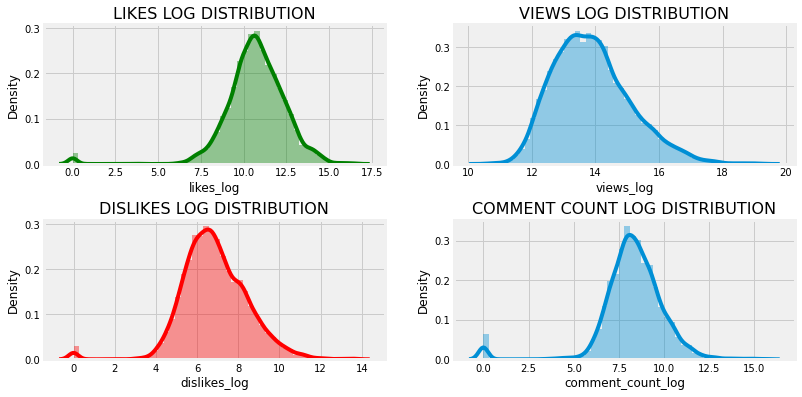

In [15]:
plt.figure(figsize = (12,6))
plt.subplot(221)
g1 = sns.distplot(df['likes_log'], color = 'green')
g1.set_title("LIKES LOG DISTRIBUTION", fontsize = 16)

plt.subplot(222)
g2 = sns.distplot(df['views_log'])
g2.set_title("VIEWS LOG DISTRIBUTION", fontsize = 16)

plt.subplot(223)
g3 = sns.distplot(df['dislikes_log'], color = 'r')
g3.set_title("DISLIKES LOG DISTRIBUTION", fontsize=16)

plt.subplot(224)
g4 = sns.distplot(df['comment_count_log'])
g4.set_title("COMMENT COUNT LOG DISTRIBUTION", fontsize=16)

plt.subplots_adjust(wspace = 0.2, hspace = 0.4, top = 0.9)

plt.show()

below we list the number of categories and assign them names since they wont be used in any analysis it will allow us to see some real trends 

In [16]:
np.unique(df["categoryId"])

array([ 1,  2, 10, 15, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29])

In [17]:
df['category_name'] = np.nan

df.loc[(df['categoryId'] == 1),  "category_name"] = 'Film and Animation'
df.loc[(df['categoryId'] == 2),  "category_name"] = 'Cars and Vehicles'
df.loc[(df['categoryId'] == 10), "category_name"] = 'Music'
df.loc[(df['categoryId'] == 15), "category_name"] = 'Pet and Animals'
df.loc[(df['categoryId'] == 17), "category_name"] = 'Sports'
df.loc[(df['categoryId'] == 19), "category_name"] = 'Travel and Events'
df.loc[(df['categoryId'] == 20), "category_name"] = 'Gaming'
df.loc[(df['categoryId'] == 22), "category_name"] = 'People and Blogs'
df.loc[(df['categoryId'] == 23), "category_name"] = 'Comedy'
df.loc[(df['categoryId'] == 24), "category_name"] = 'Entertainment'
df.loc[(df['categoryId'] == 25), "category_name"] = 'News and Politics'
df.loc[(df['categoryId'] == 26), "category_name"] = 'How to and Style'
df.loc[(df['categoryId'] == 27), "category_name"] = 'Education'
df.loc[(df['categoryId'] == 28), "category_name"] = 'Science and Technology'
df.loc[(df['categoryId'] == 29), "category_name"] = 'Non-profits and Activism'
df.loc[(df['categoryId'] == 43), "category_name"] = 'Shows'

Here we can see that there is a lot of entries in music and entertainment.

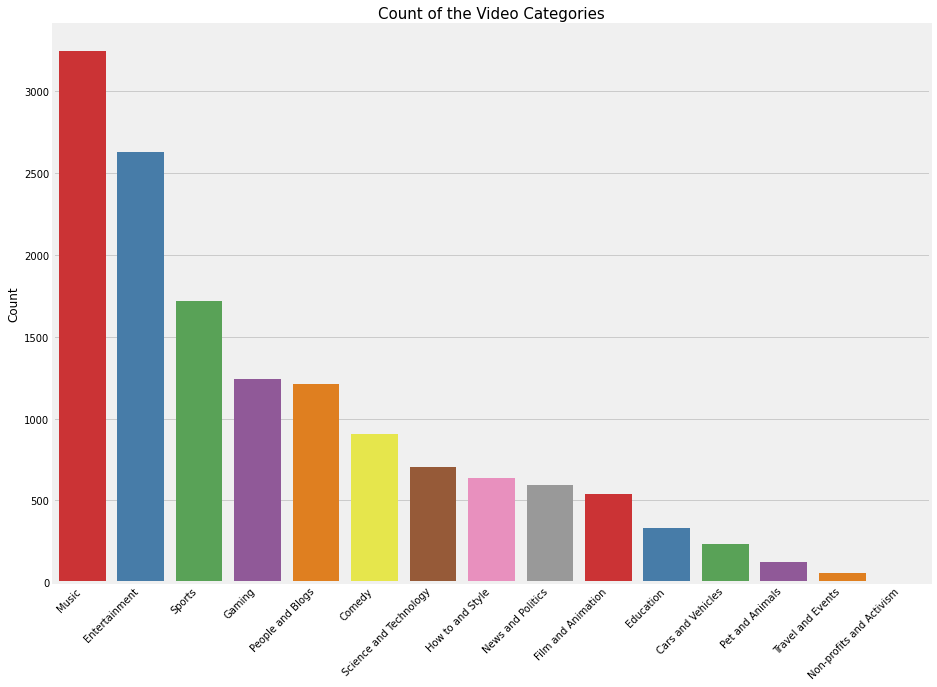

In [18]:
plt.figure(figsize = (14,10))
g = sns.countplot('category_name', data = df, palette="Set1", order = df['category_name'].value_counts().index)
g.set_xticklabels(g.get_xticklabels(),rotation=45, ha="right")
g.set_title("Count of the Video Categories", fontsize=15)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Count", fontsize=12)
plt.subplots_adjust(wspace = 0.9, hspace = 0.9, top = 0.9)
plt.show()

We can now plot box and wisker plots for each of the catergories to determine the distribution of the different features.

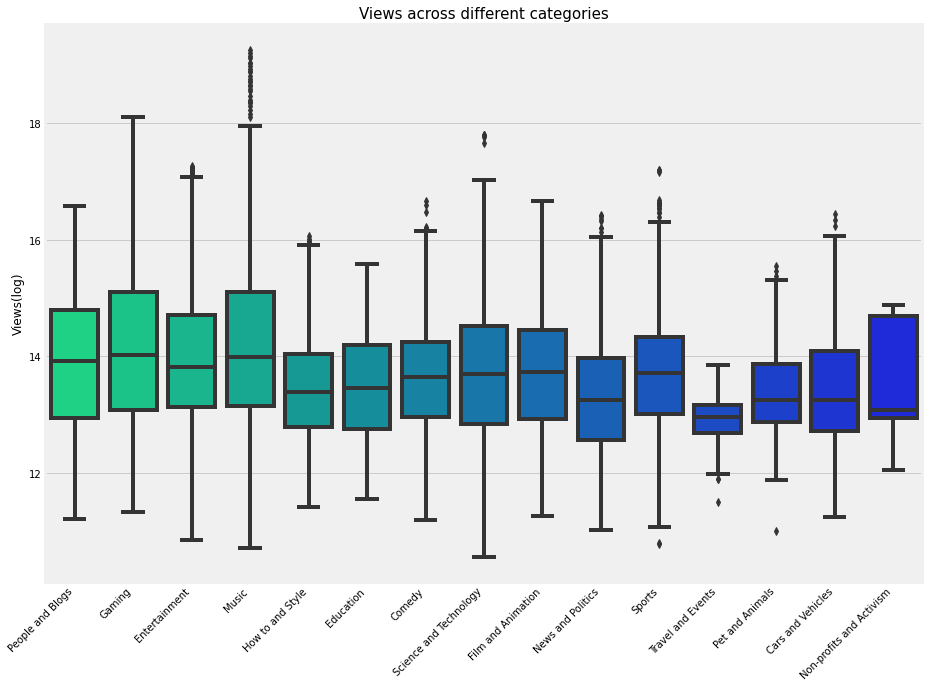

In [19]:
plt.figure(figsize = (14,10))
g = sns.boxplot(x = 'category_name', y = 'views_log', data = df, palette="winter_r")
g.set_xticklabels(g.get_xticklabels(),rotation=45, ha="right")
g.set_title("Views across different categories", fontsize=15)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Views(log)", fontsize=12)
plt.subplots_adjust(wspace = 0.9, hspace = 0.9, top = 0.9)
plt.show()

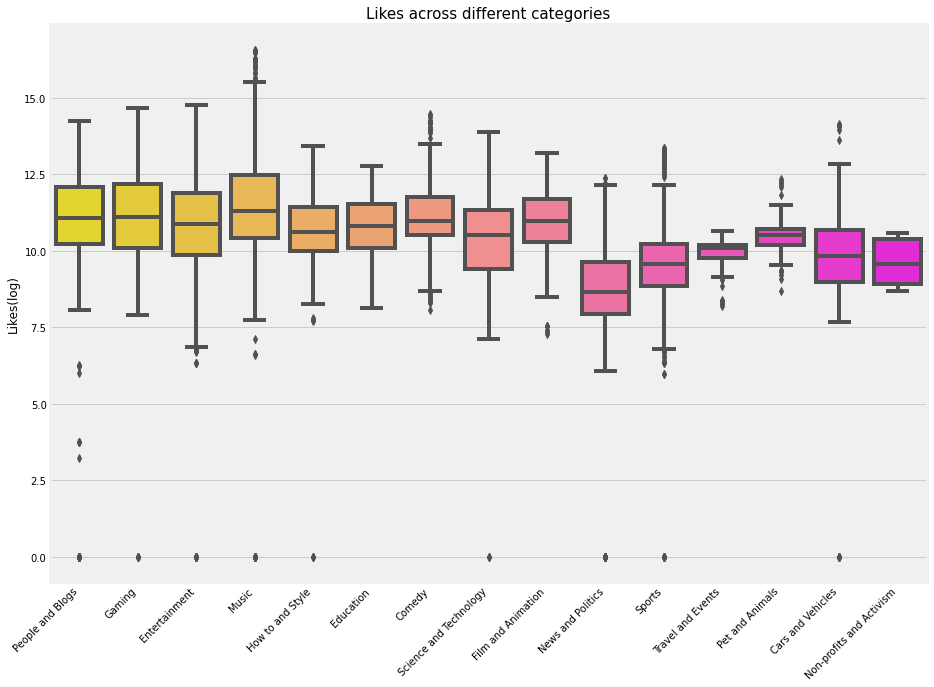

In [20]:
plt.figure(figsize = (14,10))
g = sns.boxplot(x = 'category_name', y = 'likes_log', data = df, palette="spring_r")
g.set_xticklabels(g.get_xticklabels(),rotation=45, ha="right")
g.set_title("Likes across different categories", fontsize=15)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Likes(log)", fontsize=12)
plt.subplots_adjust(wspace = 0.9, hspace = 0.9, top = 0.9)
plt.show()

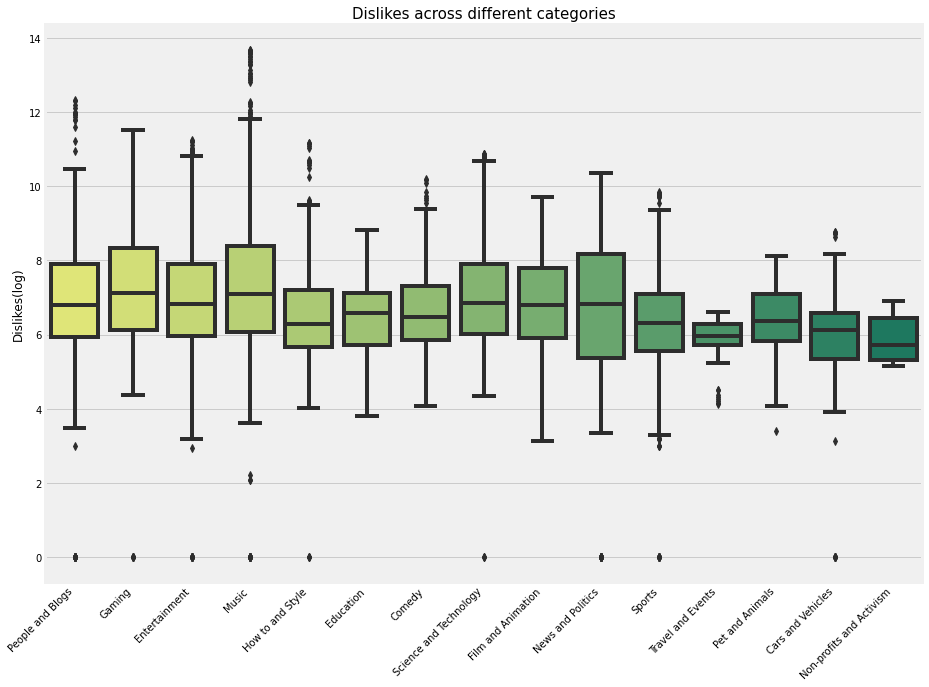

In [21]:
plt.figure(figsize = (14,10))
g = sns.boxplot(x = 'category_name', y = 'dislikes_log', data = df, palette="summer_r")
g.set_xticklabels(g.get_xticklabels(),rotation=45, ha="right")
g.set_title("Dislikes across different categories", fontsize=15)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Dislikes(log)", fontsize=12)
plt.subplots_adjust(wspace = 0.9, hspace = 0.9, top = 0.9)
plt.show()

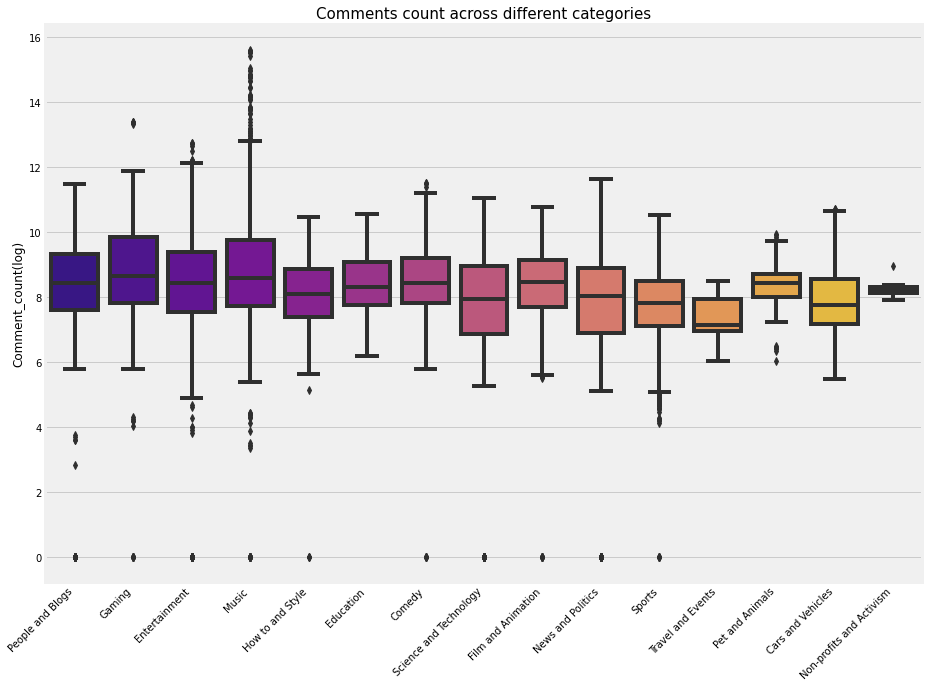

In [22]:
plt.figure(figsize = (14,10))
g = sns.boxplot(x = 'category_name', y = 'comment_count_log', data = df, palette="plasma")
g.set_xticklabels(g.get_xticklabels(),rotation=45, ha="right")
g.set_title("Comments count across different categories", fontsize=15)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Comment_count(log)", fontsize=12)
plt.subplots_adjust(wspace = 0.9, hspace = 0.9, top = 0.9)
plt.show()

Lets engineer a feature that will allow us to determine the rate of likes, dislikes, and comments per video view 

In [23]:
df['like_rate'] = df['likes']/df['view_count']
df['dislike_rate'] = df['dislikes']/df['view_count']
df['comment_rate'] = df['comment_count']/df['view_count']

We see by correlating the rates the most correlated features are the likes and comment rates and the lowest coorelated is the likes and dislikes 

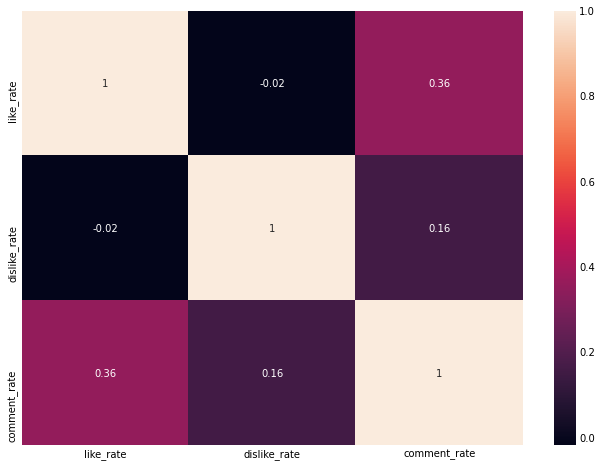

In [24]:
plt.figure(figsize = (10,8))
sns.heatmap(df[['like_rate', 'dislike_rate', 'comment_rate']].corr(), annot=True)
plt.show()

Another potentially useful feature is the length of words in the titles and tags

In [25]:
#Word count 
df['count_word']=df['title'].apply(lambda x: len(str(x).split()))
df['count_word_tags']=df['tags'].apply(lambda x: len(str(x).split()))

#Unique word count
df['count_unique_word'] = df['title'].apply(lambda x: len(set(str(x).split())))
df['count_unique_word_tags'] = df['tags'].apply(lambda x: len(set(str(x).split())))

#Punctutation count
df['count_punctuation'] = df['title'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df['count_punctuation_tags'] = df['tags'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

#Average length of the words
df['mean_word_len'] = df['title'].apply(lambda x : np.mean([len(x) for x in str(x).split()]))
df['mean_word_len_tags'] = df['tags'].apply(lambda x: np.mean([len(x) for x in str(x).split()]))

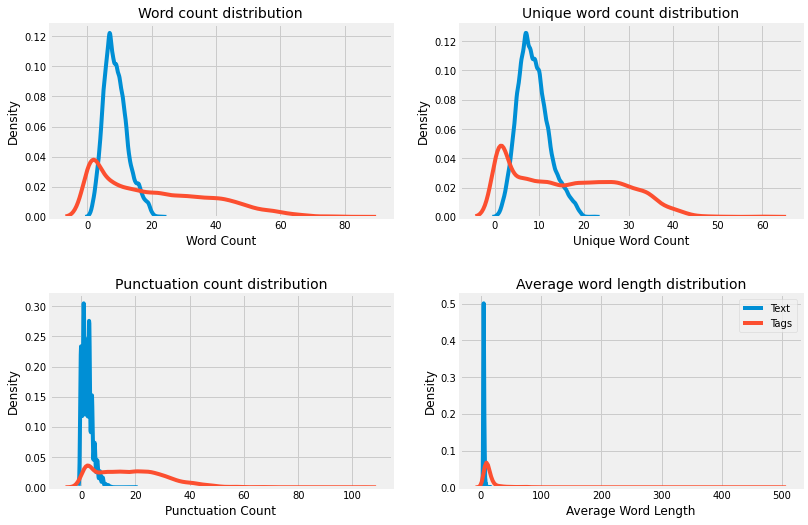

In [26]:
plt.figure(figsize = (12,18))

plt.subplot(421)
g1 = sns.distplot(df['count_word'],
                 hist = False, label = 'Text')
g1 = sns.distplot(df['count_word_tags'],
                 hist = False, label = 'Tags')
g1.set_title('Word count distribution', fontsize = 14)
g1.set(xlabel='Word Count')

plt.subplot(422)
g2 = sns.distplot(df['count_unique_word'],
                 hist = False, label = 'Text')
g2 = sns.distplot(df['count_unique_word_tags'],
                 hist = False, label = 'Tags')
g2.set_title('Unique word count distribution', fontsize = 14)
g2.set(xlabel='Unique Word Count')

plt.subplot(423)
g3 = sns.distplot(df['count_punctuation'],
                 hist = False, label = 'Text')
g3 = sns.distplot(df['count_punctuation_tags'],
                 hist = False, label = 'Tags')
g3.set_title('Punctuation count distribution', fontsize =14)
g3.set(xlabel='Punctuation Count')

plt.subplot(424)
g4 = sns.distplot(df['mean_word_len'],
                 hist = False, label = 'Text')
g4 = sns.distplot(df['mean_word_len_tags'],
                 hist = False, label = 'Tags')
g4.set_title('Average word length distribution', fontsize = 14)
g4.set(xlabel = 'Average Word Length')

plt.subplots_adjust(wspace = 0.2, hspace = 0.4, top = 0.9)
plt.legend()
plt.show()

# Title and tag specific visuialization and frequency analysis 

In [27]:
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(40, 200)

To visualize the most popular tags we are creating a wordcloud 

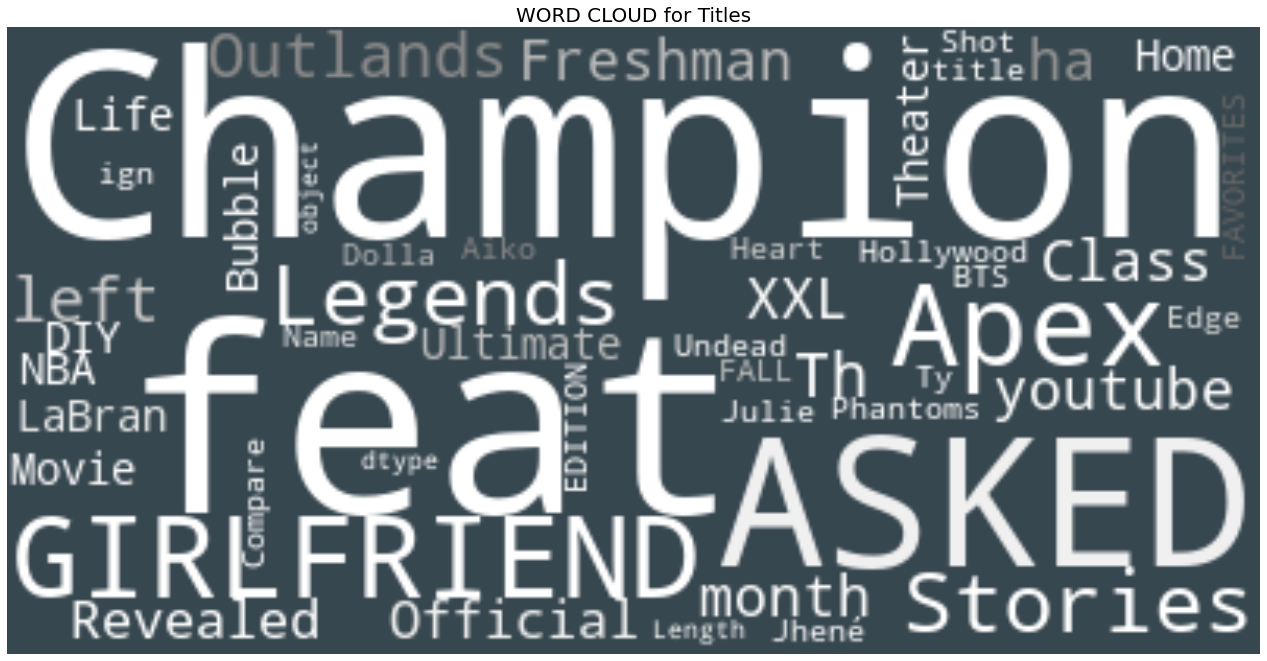

In [28]:
import os
import random
plt.figure(figsize = (20,20))
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                      background_color = '#37474fff',
                      stopwords=stopwords,
                      max_words = 1000,
                      max_font_size = 120,
                      random_state = 42
                    ).generate(str(df['title']))

#Plotting the word cloud
default_colors = wordcloud.to_array(),
plt.imshow(wordcloud.recolor(color_func=grey_color_func, random_state=3),interpolation="bilinear")
plt.title("WORD CLOUD for Titles", fontsize = 20)
plt.axis('off')
plt.show()

In [29]:
all_titles = ' '.join(df['title'].str.lower())

import re

def tokens(text):
    "List all the word tokens in a text."
    return re.findall('[\w]+', text.lower())
new_titles=tokens(all_titles)


filtered_words = [word for word in new_titles if word not in stopwords]
counted_words = collections.Counter(filtered_words)

words = []
counts = []
for letter, count in counted_words.most_common(40):
    words.append(letter)
    counts.append(count)

Lets plot the top 50 words to see if we can see more trends between the words in the titles. There are some words like music and video that are used together often leading to high counts of both words. Lets do the same thing but for tags as well

<BarContainer object of 40 artists>

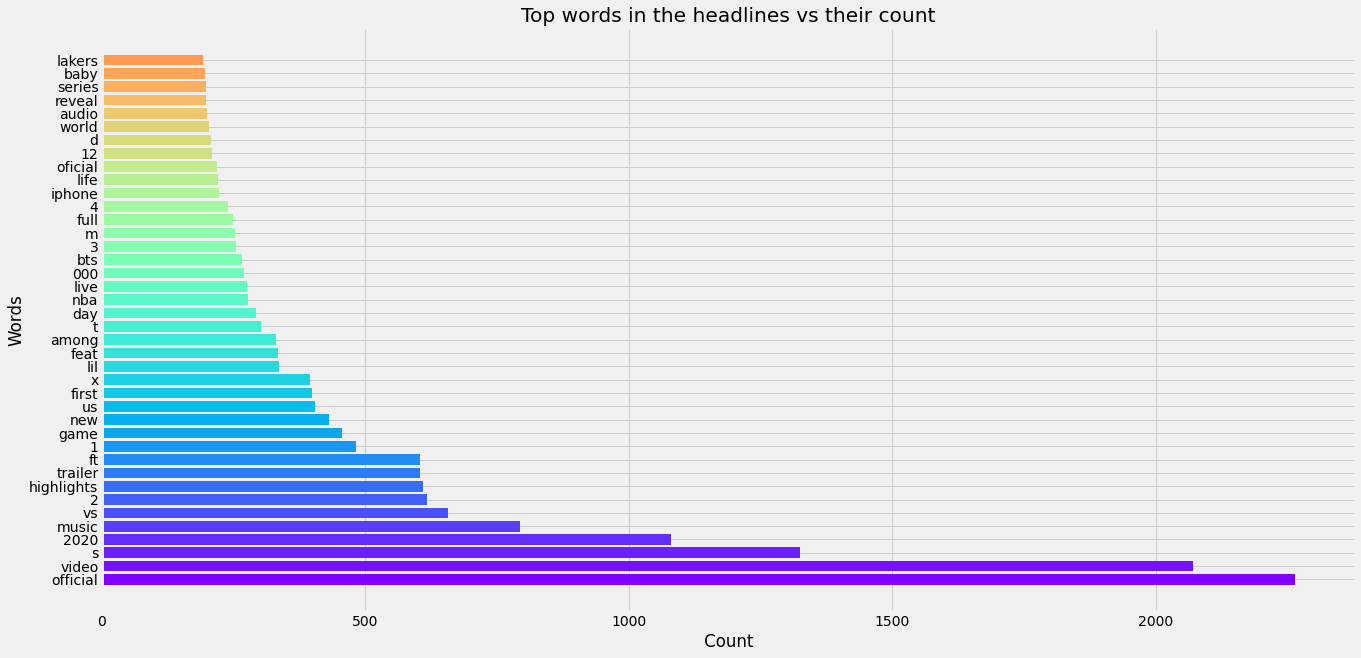

In [100]:
colors = cm.rainbow(np.linspace(0, 1, 50))
rcParams['figure.figsize'] = 20, 10

plt.title('Top words in the headlines vs their count')
plt.xlabel('Count')
plt.ylabel('Words')
plt.style.use('fivethirtyeight')
plt.barh(words, counts, color=colors)

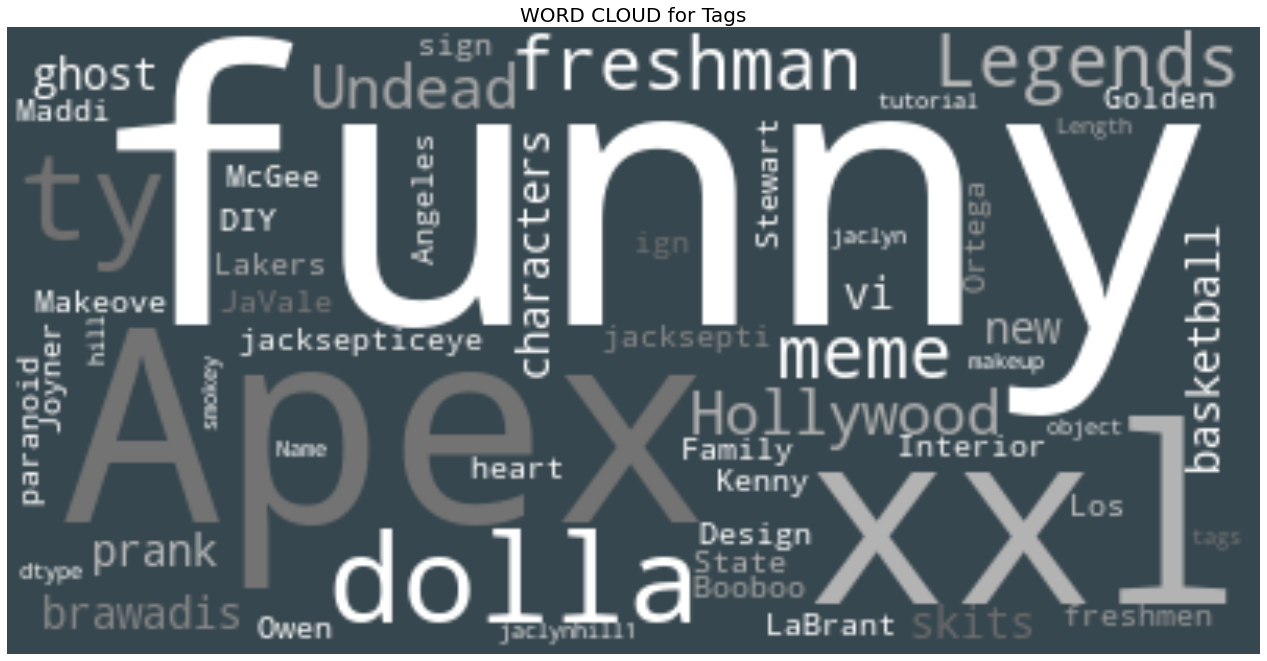

In [31]:
plt.figure(figsize = (20,20))

stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                      background_color = '#37474fff',
                      stopwords = stopwords,
                      max_words = 1000,
                      max_font_size = 120,
                      random_state = 42
                    ).generate(str(df['tags']))

#Plotting the word cloud
default_colors = wordcloud.to_array(),
plt.imshow(wordcloud.recolor(color_func=grey_color_func, random_state=3),interpolation="bilinear")
plt.title("WORD CLOUD for Tags", fontsize = 20)
plt.axis('off')
plt.show()


In [32]:
all_tags = ' '.join(df['tags'].str.lower())

import re

def tokens(text):
    "List all the word tokens in a text."
    return re.findall('[\w]+', text.lower())
new_tags=tokens(all_tags)


filtered_words = [word for word in new_tags if word not in stopwords]
counted_words = collections.Counter(filtered_words)

tag_words = []
tag_counts = []
for letter, count in counted_words.most_common(40):
    tag_words.append(letter)
    tag_counts.append(count)

<BarContainer object of 40 artists>

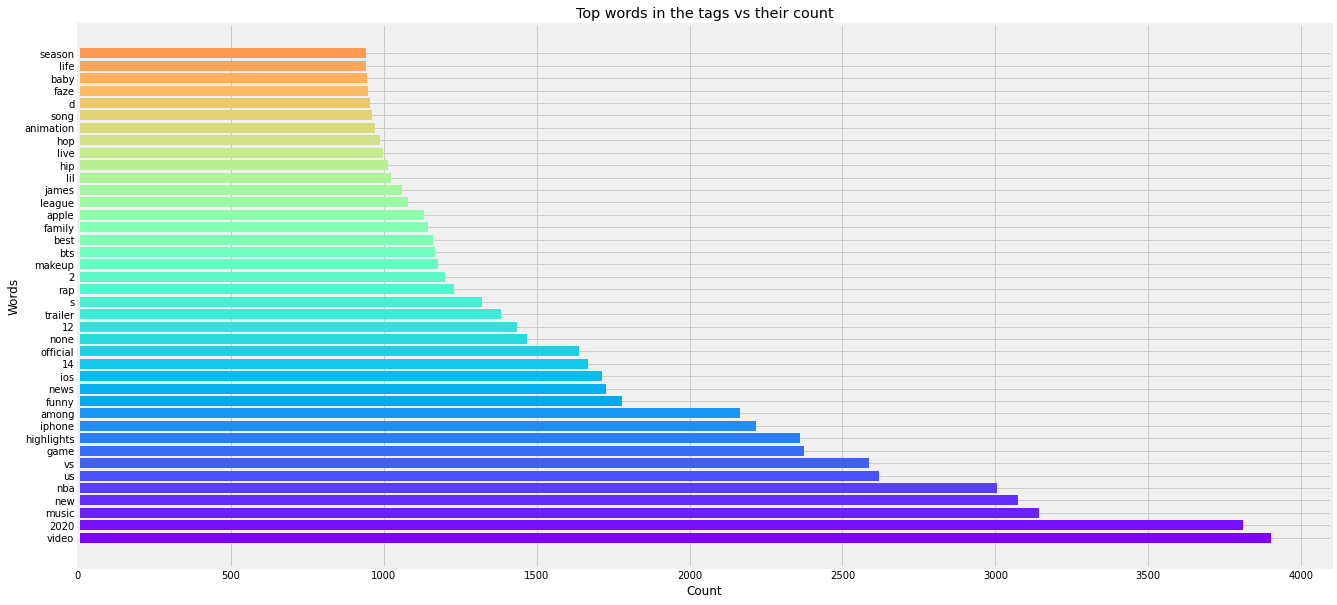

In [33]:
colors = cm.rainbow(np.linspace(0, 1, 50))
rcParams['figure.figsize'] = 20, 10

plt.title('Top words in the tags vs their count')
plt.xlabel('Count')
plt.ylabel('Words')
plt.style.use('fivethirtyeight')
plt.barh(tag_words, tag_counts, color=colors)

In [34]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
split_tags=df.tags.str.split('|', expand=False) #splits the string based on |
print(split_tags)

df['tags']=split_tags



0        [brawadis, prank, basketball, skits, ghost, fu...
1        [Apex Legends, Apex Legends characters, new Ap...
2        [jacksepticeye, funny, funny meme, memes, jack...
3        [xxl freshman, xxl freshmen, 2020 xxl freshman...
4        [The LaBrant Family, DIY, Interior Design, Mak...
                               ...                        
14193    [JaVale McGee, Los Angeles Lakers, Golden Stat...
14194    [Hollywood Undead, hollywood undead heart of a...
14195    [ty dolla $ign, ty dolla sign paranoid, ty dol...
14196    [Kenny Ortega, Booboo Stewart, Owen Joyner, Ma...
14197    [jaclynhill1, jaclyn hill, makeup tutorial, sm...
Name: tags, Length: 14198, dtype: object


# Google trends API

We can interface with google trends api to get information on the past trends of a tag or word in the title of a video on youtube. Here we will go through the process of extracting that information from the wordclouds and setting the hyperparamaters for the google trends request.

In [35]:
!pip install pytrends


In [36]:
import pandas as pd
from pytrends.request import TrendReq
pytrend = TrendReq(hl='en-US', tz=360)

**timeframe**

Date to start from

Defaults to last 5yrs, 'today 5-y'.

Everything 'all'

Specific dates, 'YYYY-MM-DD YYYY-MM-DD' example '2016-12-14 2017-01-25'

Specific datetimes, 'YYYY-MM-DDTHH YYYY-MM-DDTHH' example '2017-02-06T10 2017-02-12T07'

Note Time component is based off UTC
Current Time Minus Time Pattern:

By Month: 'today #-m' where # is the number of months from that date to pull data for

For example: 'today 3-m' would get data from today to 3months ago
NOTE Google uses UTC date as 'today'
Seems to only work for 1, 2, 3 months only
Daily: 'now #-d' where # is the number of days from that date to pull data for

For example: 'now 7-d' would get data from the last week
Seems to only work for 1, 7 days only
Hourly: 'now #-H' where # is the number of hours from that date to pull data for

For example: 'now 1-H' would get data from the last hour
Seems to only work for 1, 4 hours only

**kw_list**

keywords to get data for

Example ['Pizza']

Up to five terms in a list: ['Pizza', 'Italian', 'Spaghetti', 'Breadsticks', 'Sausage']

Advanced Keywords

When using Google Trends dashboard Google may provide suggested narrowed search terms.
For example "iron" will have a drop down of "Iron Chemical Element, Iron Cross, Iron Man, etc".
Find the encoded topic by using the get_suggestions() function and choose the most relevant one for you.
For example: https://www.google.com/trends/explore#q=%2Fm%2F025rw19&cmpt=q
"%2Fm%2F025rw19" is the topic "Iron Chemical Element" to use this with pytrends
You can also use pytrends.suggestions() to automate this.

**gprop**

What Google property to filter to
Example 'images'
Defaults to web searches
Can be images, news, youtube or froogle (for Google Shopping results)

Below is the format for building payloads for the pytrends API

```
#kw_list = ["Blockchain"]
pytrends.build_payload(kw_list, cat=0, timeframe='today 5-y', geo='', gprop='')
```



In [37]:
df_tags = pd.DataFrame(data=tag_words,columns=['tags'])
df_tags['counts'] = tag_counts
df_tags.head()

,tags,counts
0,video,3902
1,2020,3811
2,music,3143
3,new,3074
4,nba,3004


In [38]:
kw_list = df_tags['tags'].head(5).values.tolist()
print(kw_list)


['video', '2020', 'music', 'new', 'nba']


Below are the trends for the top 5 tags from the videos in the US on youtube, The x axis is based on a percentage normalized to the top search so the trends are not compairable to eachother. 

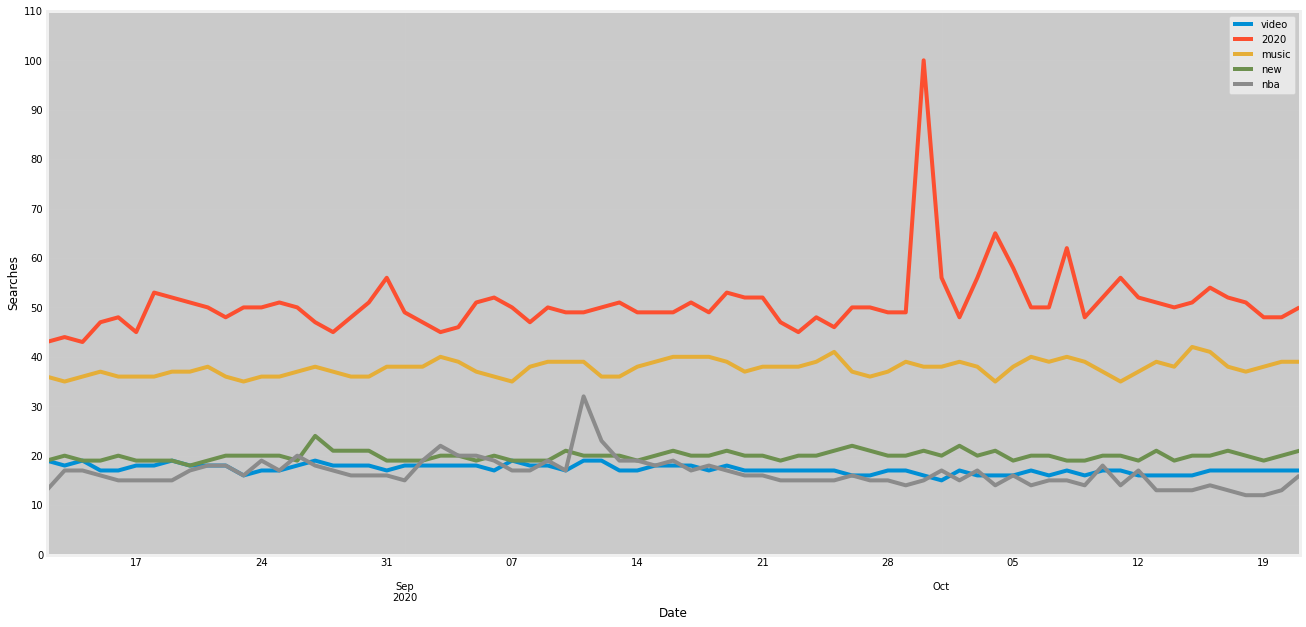

In [39]:
kw_list = df_tags['tags'].head(5).values.tolist()
timeframe='2020-08-12 2020-10-21'


pytrend.build_payload(kw_list, timeframe=timeframe, geo='US', gprop='youtube')
trends = pytrend.interest_over_time()
ax=trends.plot()


ax.set_xlabel('Date',color='black')
ax.set_ylabel('Searches',color='black')
ax.patch.set_facecolor('#cacacaff')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
ax.set_ylim(0,110)  # ajust y axis range fo r numeric input
ax.set_yticks(np.arange(0, 110 + 1, 10))  # adjust the y tick frequency
ax.legend(bbox_to_anchor=(0.99, 12)) #customise the legend location

plt.legend()
plt.show()


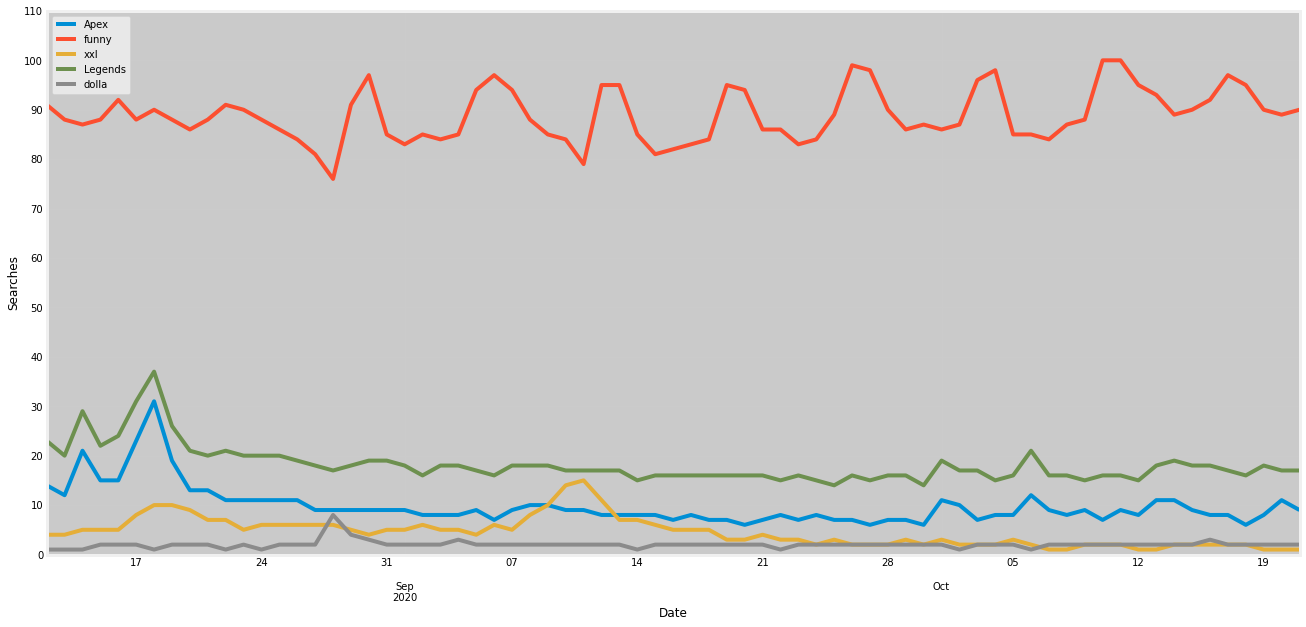

In [40]:
kw_list = ['Apex','funny', 'xxl', 'Legends','dolla']
timeframe='2020-08-12 2020-10-21'


pytrend.build_payload(kw_list, timeframe=timeframe, geo='US', gprop='youtube')
trends = pytrend.interest_over_time()
ax=trends.plot()



ax.set_xlabel('Date',color='black')
ax.set_ylabel('Searches',color='black')
ax.patch.set_facecolor('#cacacaff')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
ax.set_ylim(0,110)  # ajust y axis range fo r numeric input
ax.set_yticks(np.arange(0, 110 + 1, 10))  # adjust the y tick frequency
ax.legend(bbox_to_anchor=(0.99, 12)) #customise the legend location

plt.legend()
plt.show()

# Time Series forcasting on Apex

In [41]:
pytrend.build_payload(kw_list=kw_list, timeframe=timeframe, geo='US', gprop='youtube')
trends = pytrend.interest_over_time()
trends = trends.set_index(pd.to_datetime(trends.index))

In [42]:
series = pd.Series(trends['Apex'].values, index = trends.index)


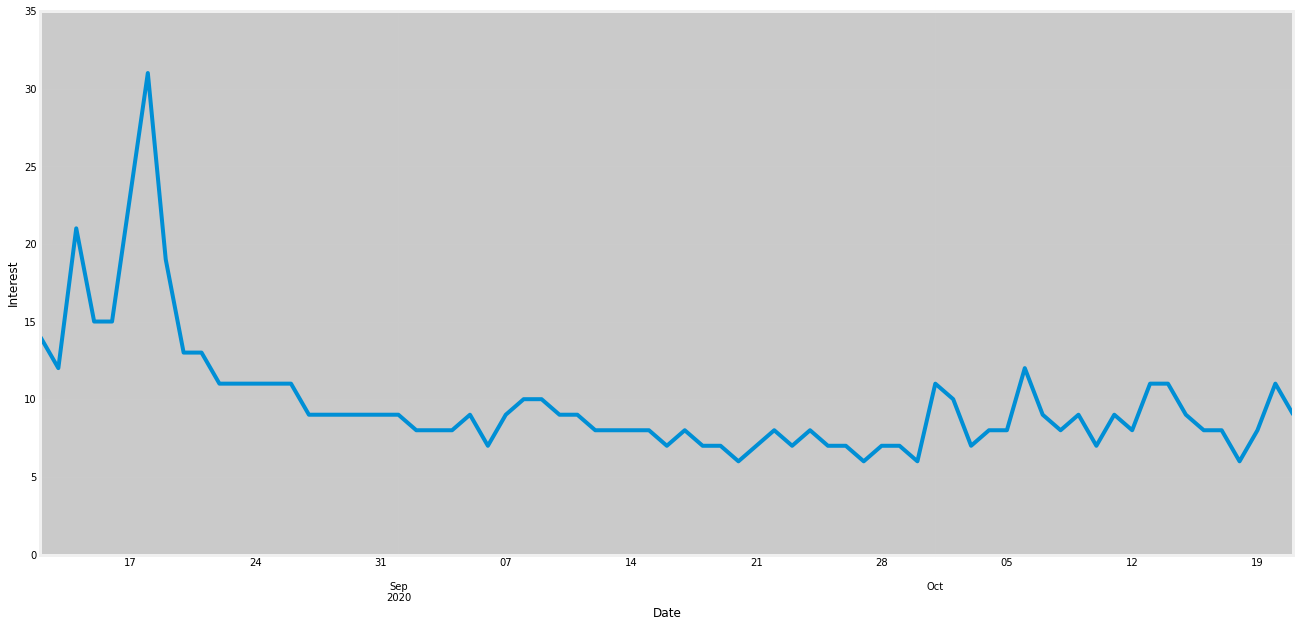

In [43]:
ax=series.plot()
ax.set_xlabel('Date',color='black')
ax.set_ylabel('Interest',color='black')
ax.patch.set_facecolor('#cacacaff')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
ax.set_ylim(0,35)  # ajust y axis range fo r numeric input
ax.set_yticks(np.arange(0, 35 + 1, 5))  # adjust the y tick frequency
plt.style.use('fivethirtyeight')
plt.show()

## Holt winters model

Splitting the set to do 3 fold cross validation 

In [44]:
from sklearn.model_selection import TimeSeriesSplit
#Specify fold and perform splitting
tscv = TimeSeriesSplit(n_splits=3)
tscv.split(trends)
#Find out no of observations in train and test sets
i=0
for train, test in tscv.split(trends):
    i=i+1
    print ("No of observations under train%s=%s" % (i, len(train)))
    print ("No of observations under test%s=%s" % (i, len(test)))

No of observations under train1=20
No of observations under test1=17
No of observations under train2=37
No of observations under test2=17
No of observations under train3=54
No of observations under test3=17


In [45]:
#Splitting according to the above description
train1, test1 = trends.iloc[:20, 0], trends.iloc[20:37, 0]
train2, test2 = trends.iloc[:37, 0], trends.iloc[37:54, 0]
train3, test3 = trends.iloc[:54, 0], trends.iloc[54:71, 0]

The Holt-Winters seasonal method comprises the forecast equation and three smoothing equations

There are two variations to this method that differ in the nature of the seasonal component. The additive method is preferred when the seasonal variations are roughly constant through the series, while the multiplicative method is preferred when the seasonal variations are changing proportional to the level of the series. With the additive method, the seasonal component is expressed in absolute terms in the scale of the observed series, and in the level equation the series is seasonally adjusted by subtracting the seasonal component. Within each year, the seasonal component will add up to approximately zero. With the multiplicative method, the seasonal component is expressed in relative terms (percentages), and the series is seasonally adjusted by dividing through by the seasonal component. Within each year, the seasonal component will sum up to approximately  

https://otexts.com/fpp2/holt-winters.html

In [46]:

#Fit a model
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt

#First fold RMSE
model1 = ExponentialSmoothing(train1, seasonal='mul', seasonal_periods=12).fit()
pred1 = model1.predict(start=test1.index[0], end=test1.index[-1])
RMSE1=round(sqrt(mean_squared_error(test1, pred1)),2)

#Second fold RMSE
model2 = ExponentialSmoothing(train2, seasonal='mul', seasonal_periods=12).fit()
pred2 = model2.predict(start=test2.index[0], end=test2.index[-1])
RMSE2=round(sqrt(mean_squared_error(test2, pred2)),2)

#Third fold RMSE
model3 = ExponentialSmoothing(train3, seasonal='mul', seasonal_periods=12).fit()
pred3 = model3.predict(start=test3.index[0], end=test3.index[-1])
RMSE3=round(sqrt(mean_squared_error(test3, pred3)),2)

print ("RMSE1:", RMSE1)
print ("RMSE2:", RMSE2)
print ("RMSE3:", RMSE3)

Overall_RMSE=round((RMSE1+RMSE2+RMSE3)/3,2)
print ("Overall RMSE:", Overall_RMSE) 

RMSE1: 2.03
RMSE2: 3.07
RMSE3: 2.53
Overall RMSE: 2.54


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


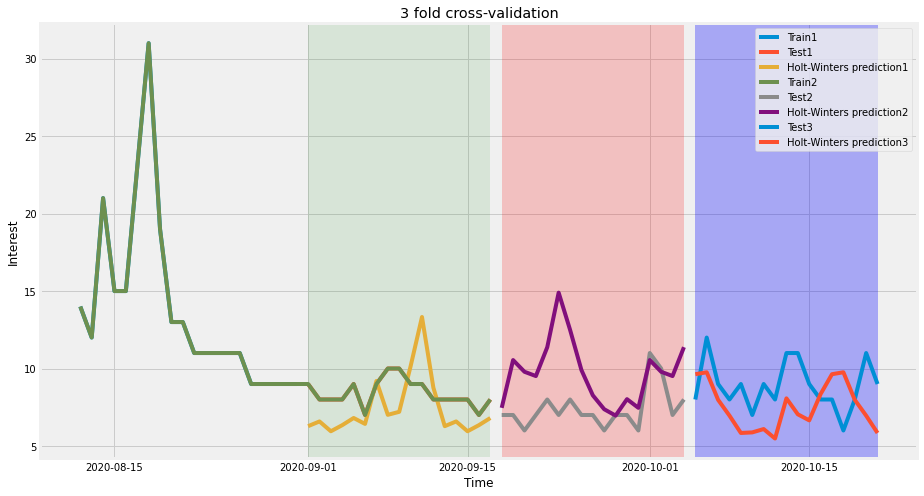

In [47]:
#Import libraries

rcParams['figure.figsize'] = 14,8

#Labels and titles
plt.xlabel("Time")
plt.ylabel("Interest")
plt.title("3 fold cross-validation")

#First fold- CV
plt.plot(train1.index, train1, label='Train1')
plt.plot(test1.index, test1, label='Test1')
plt.plot(pred1.index, pred1, label='Holt-Winters prediction1')
plt.legend(loc='best')
#Highlighting the region
plt.axvspan(test1.index[0], test1.index[-1],  facecolor='g', alpha=0.1)

#Second fold
plt.plot(train2.index, train2, label='Train2')
plt.plot(test2.index, test2, label='Test2')
plt.plot(pred2.index, pred2, label='Holt-Winters prediction2')
plt.legend(loc='best')
#Highlighting the region
plt.axvspan(test2.index[0], test2.index[-1],  facecolor='r', alpha=0.2)

#Third fold
plt.plot(test3.index, test3, label='Test3')
plt.plot(pred3.index, pred3, label='Holt-Winters prediction3')
plt.legend(loc='best')
#Highlighting the region
plt.style.use('fivethirtyeight')
plt.axvspan(test3.index[0], test3.index[-1],  facecolor='b', alpha=0.3)


## SARMA model

In [48]:
series = series.resample('d').mean()


Some distinguishable patterns appear when we plot the data. We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.


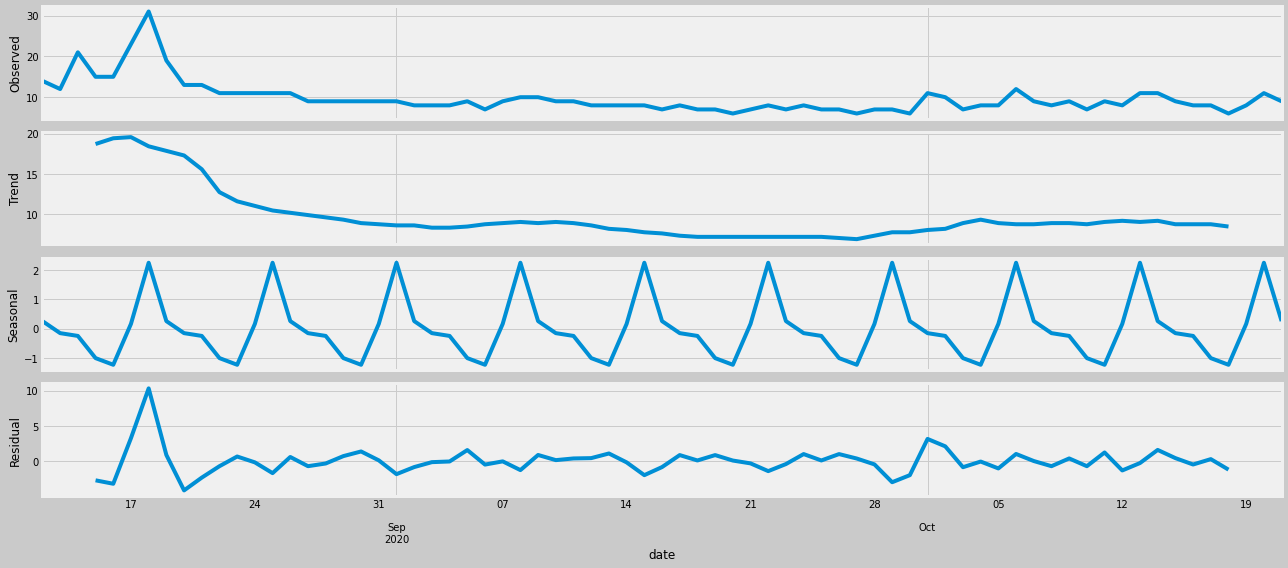

In [49]:
#The best part about time series data and decomposition is that you can break down the data into the following:
#Time Series Decomposition. 
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(series, model='additive')
fig = decomposition.plot()
fig.patch.set_facecolor('#cacacaff')
plt.style.use('fivethirtyeight')
plt.show()



ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

This step is parameter Selection for our furniture’s sales ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.


In [50]:
#GRID SEARCH for Param Tuning.
#Sample params for seasonal arima. (SARIMAX).

#For each combination of parameters, we fit a new seasonal ARIMA model with the SARIMAX() function 
#from the statsmodels module and assess its overall quality.

import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 26) for x in list(itertools.product(p, d, q))]

In [51]:

#The code tests the given params using sarimax and outputs the AIC scores.

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(series,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{}26 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue




SARIMA(0, 0, 0)x(0, 0, 0, 26)26 - AIC:530.5164268809511
SARIMA(0, 0, 0)x(0, 1, 0, 26)26 - AIC:276.9834850184603
SARIMA(0, 0, 0)x(1, 0, 0, 26)26 - AIC:249.03229831877672
SARIMA(0, 0, 0)x(1, 1, 0, 26)26 - AIC:83.80773429559108
SARIMA(0, 0, 1)x(0, 0, 0, 26)26 - AIC:449.4198875262741
SARIMA(0, 0, 1)x(0, 1, 0, 26)26 - AIC:245.28400506757595
SARIMA(0, 0, 1)x(1, 0, 0, 26)26 - AIC:223.54314963251318
SARIMA(0, 0, 1)x(1, 1, 0, 26)26 - AIC:82.13366703086677
SARIMA(0, 1, 0)x(0, 0, 0, 26)26 - AIC:342.901144214635
SARIMA(0, 1, 0)x(0, 1, 0, 26)26 - AIC:235.90731733335463
SARIMA(0, 1, 0)x(1, 0, 0, 26)26 - AIC:173.72659932391505
SARIMA(0, 1, 0)x(1, 1, 0, 26)26 - AIC:81.00829567809643
SARIMA(0, 1, 1)x(0, 0, 0, 26)26 - AIC:327.8262241396725
SARIMA(0, 1, 1)x(0, 1, 0, 26)26 - AIC:226.13010881249875
SARIMA(0, 1, 1)x(1, 0, 0, 26)26 - AIC:163.97089014949321
SARIMA(0, 1, 1)x(1, 1, 0, 26)26 - AIC:79.1263709361395
SARIMA(1, 0, 0)x(0, 0, 0, 26)26 - AIC:347.4844740325177
SARIMA(1, 0, 0)x(0, 1, 0, 26)26 - AIC:237.5

In [52]:
#Fit the model with the best params.
#SARIMA(1, 1, 1)x(1, 1, 0, 26)26 - AIC:75.10194249234047

#we should consider this to be optimal option.

from statsmodels.tsa.statespace.sarimax import SARIMAX
mod = sm.tsa.statespace.SARIMAX(series,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 26),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3249      0.342      0.950      0.342      -0.345       0.995
ma.L1         -1.0000   3197.319     -0.000      1.000   -6267.630    6265.630
ar.S.L26       0.0098      0.136      0.072      0.943      -0.257       0.276
sigma2         2.7563   8812.534      0.000      1.000   -1.73e+04    1.73e+04


It is not perfect, however, our model diagnostics suggests that the model residuals are near normally distributed.

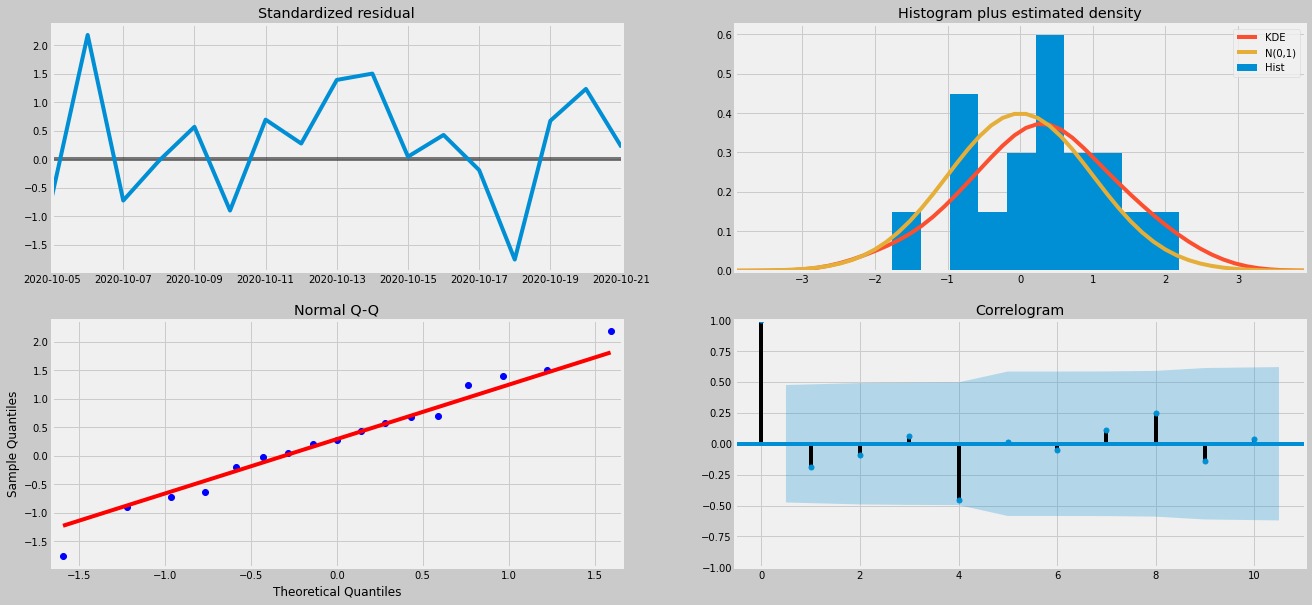

In [53]:
#Plotting the diagnostics.

#The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.
fig=results.plot_diagnostics(figsize=(20,10))
fig.patch.set_facecolor('#cacacaff')
plt.style.use('fivethirtyeight')
plt.show()


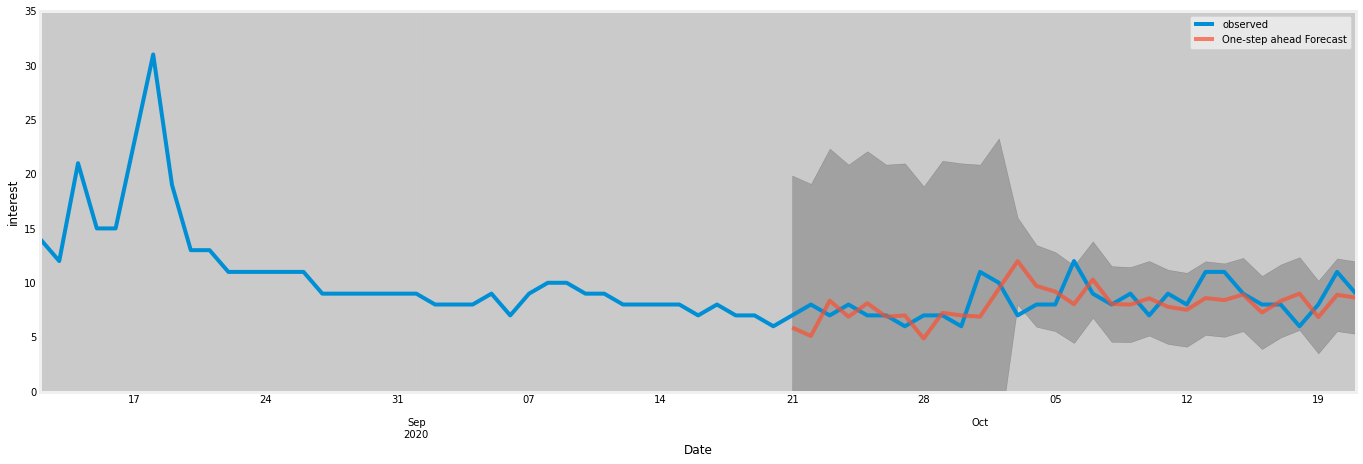

In [54]:
#Lets get the predictions and confidence interval for those predictions.
#Get the predictions. The forecasts start from the 1st of Jan 2017 but the previous line shows how it fits to the data.
pred = results.get_prediction(start=pd.to_datetime('2020-09-21'), dynamic=False) #false is when using the entire history.
#Confidence interval.
pred_ci = pred.conf_int()

#Plotting real and forecasted values.
ax = series.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(21, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date',color='black')
ax.set_ylabel('interest',color='black')
ax.patch.set_facecolor('#cacacaff')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

ax.set_ylim(0,35)  # ajust y axis range for numeric input
ax.set_yticks(np.arange(0, 35 + 1, 5))  # adjust the y tick frequency
ax.legend(bbox_to_anchor=(0.99, 12)) #customise the legend location
plt.legend()
plt.style.use('fivethirtyeight')
plt.show()

#Takeaway: The forecats seems to be fitting well to the data. The Blue/purple thicker plot shows the confidence level in the forecasts. 

In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator — it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.
Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily interest in the  test set within 3.89 of the real interest. Our furniture daily sales range from around 10 to over 30. In my opinion, this is a pretty good model so far.

In [55]:
#Getting the mean squared error (average error of forecasts).
y_forecasted = pred.predicted_mean
y_truth = series['2020-09-22':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('MSE {}'.format(round(mse, 2)))

#Smaller the better.

MSE 3.89


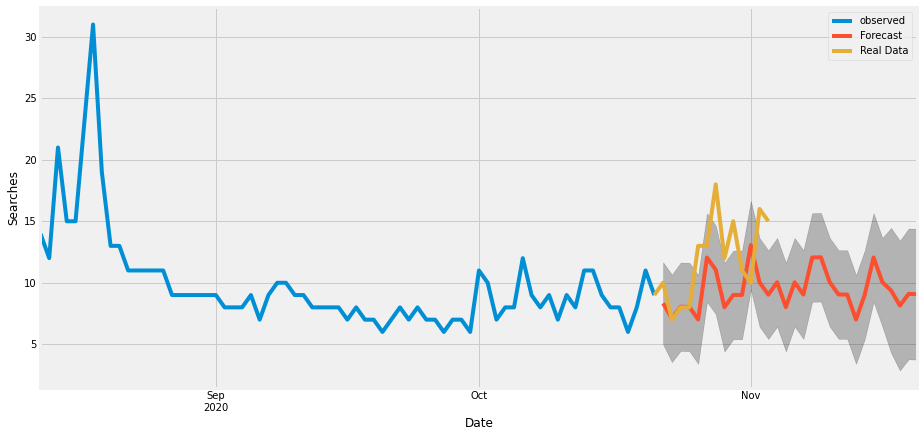

In [56]:
timeframe='2020-10-21 2020-11-09'
pytrend.build_payload(kw_list, timeframe=timeframe, geo='US', gprop='youtube')
trends_test = pytrend.interest_over_time()
trends_test= trends_test.set_index(pd.to_datetime(trends_test.index))
series_test = pd.Series(trends_test['Apex'].values, index = trends_test.index)


#The time can be changed using steps.
pred_uc = results.get_forecast(steps=30)
pred_ci = pred_uc.conf_int(95)
ax = series.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax1=series_test.plot(label='Real Data')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date',color='black')
ax.set_ylabel('Searches',color='black')
#ax.patch.set_facecolor('#cacacaff')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

#ax.set_ylim(0,40)  # ajust y axis range for numeric input
#ax.set_yticks(np.arange(0, 40 + 1, 5))  # adjust the y tick frequency
ax.legend(bbox_to_anchor=(0.99, 12)) #customise the legend location
plt.legend()
plt.style.use('fivethirtyeight')
plt.show()


# Time Series forcasting on 'dolla'

In [57]:
kw_list = ['Apex','funny', 'xxl', 'Legends','dolla']
timeframe='2020-08-12 2020-10-21'
pytrend.build_payload(kw_list, timeframe=timeframe, geo='US', gprop='youtube')
trends = pytrend.interest_over_time()
trends = trends.set_index(pd.to_datetime(trends.index))

In [58]:
series = pd.Series(trends['dolla'].values, index = trends.index)


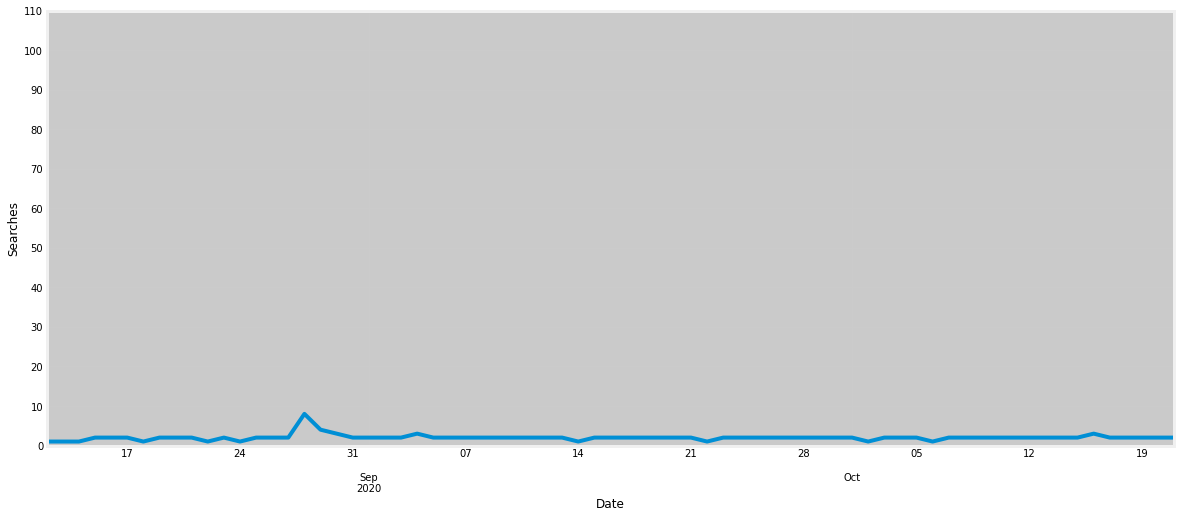

In [59]:

ax=series.plot()
ax.set_xlabel('Date',color='black')
ax.set_ylabel('Searches',color='black')
ax.patch.set_facecolor('#cacacaff')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
ax.set_ylim(0,20)  # ajust y axis range fo r numeric input
ax.set_yticks(np.arange(0, 20 + 1, 10))  # adjust the y tick frequency
plt.style.use('fivethirtyeight')
plt.show()


##Holt Winters model

In [60]:
#Splitting according to the above description
train1, test1 = trends.iloc[:20, 0], trends.iloc[20:37, 0]
train2, test2 = trends.iloc[:37, 0], trends.iloc[37:54, 0]
train3, test3 = trends.iloc[:54, 0], trends.iloc[54:71, 0]

In [61]:

#Fit a model
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt

#First fold RMSE
model1 = ExponentialSmoothing(train1, seasonal='mul', seasonal_periods=7).fit()
pred1 = model1.predict(start=test1.index[0], end=test1.index[-1])
RMSE1=round(sqrt(mean_squared_error(test1, pred1)),2)

#Second fold RMSE
model2 = ExponentialSmoothing(train2, seasonal='mul', seasonal_periods=7).fit()
pred2 = model2.predict(start=test2.index[0], end=test2.index[-1])
RMSE2=round(sqrt(mean_squared_error(test2, pred2)),2)

#Third fold RMSE
model3 = ExponentialSmoothing(train3, seasonal='mul', seasonal_periods=7).fit()
pred3 = model3.predict(start=test3.index[0], end=test3.index[-1])
RMSE3=round(sqrt(mean_squared_error(test3, pred3)),2)

print ("RMSE1:", RMSE1)
print ("RMSE2:", RMSE2)
print ("RMSE3:", RMSE3)

Overall_RMSE=round((RMSE1+RMSE2+RMSE3)/3,2)
print ("Overall RMSE:", Overall_RMSE) 

RMSE1: 2.11
RMSE2: 1.32
RMSE3: 1.94
Overall RMSE: 1.79


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


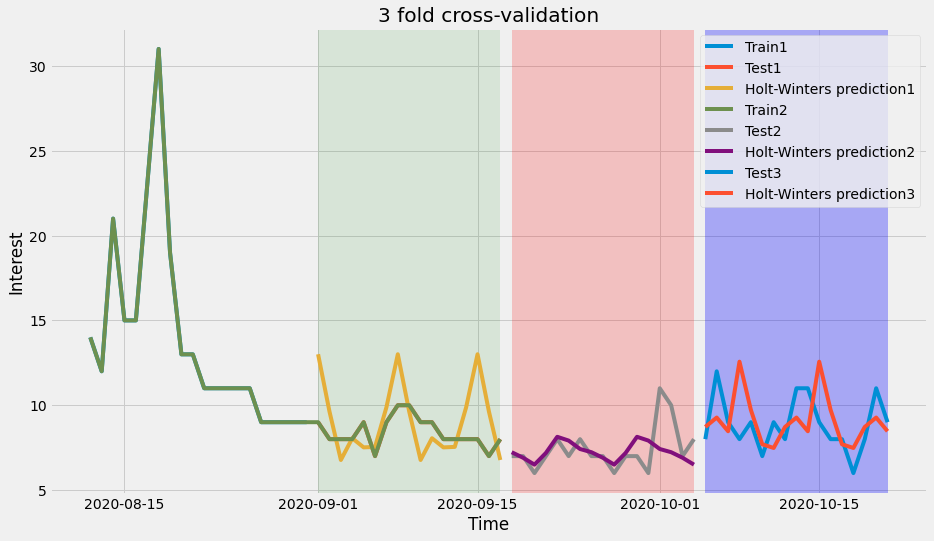

In [62]:
#Import libraries

plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 14,8

#Labels and titles
plt.xlabel("Time")
plt.ylabel("Interest")
plt.title("3 fold cross-validation")

#First fold- CV
plt.plot(train1.index, train1, label='Train1')
plt.plot(test1.index, test1, label='Test1')
plt.plot(pred1.index, pred1, label='Holt-Winters prediction1')
plt.legend(loc='best')
#Highlighting the region
plt.axvspan(test1.index[0], test1.index[-1],  facecolor='g', alpha=0.1)

#Second fold
plt.plot(train2.index, train2, label='Train2')
plt.plot(test2.index, test2, label='Test2')
plt.plot(pred2.index, pred2, label='Holt-Winters prediction2')
plt.legend(loc='best')
#Highlighting the region
plt.axvspan(test2.index[0], test2.index[-1],  facecolor='r', alpha=0.2)

#Third fold
plt.plot(test3.index, test3, label='Test3')
plt.plot(pred3.index, pred3, label='Holt-Winters prediction3')
plt.legend(loc='best')
#Highlighting the region
plt.axvspan(test3.index[0], test3.index[-1],  facecolor='b', alpha=0.3)


## SARMA model

In [63]:
series = series.resample('d').mean()


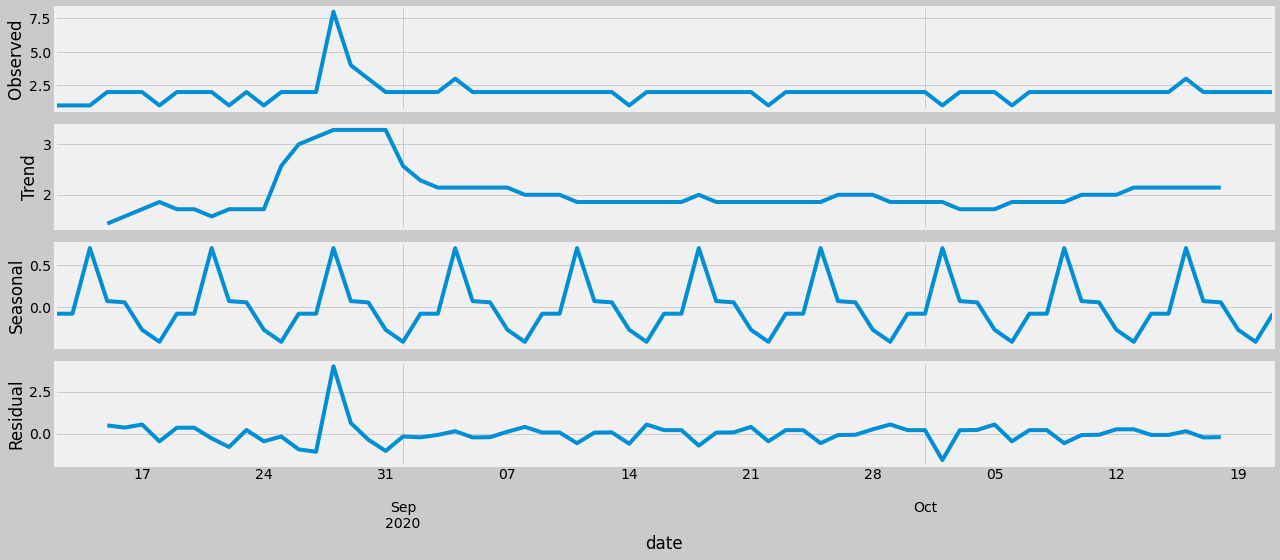

In [64]:
#The best part about time series data and decomposition is that you can break down the data into the following:
#Time Series Decomposition. 

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(series, model='additive')
fig = decomposition.plot()
fig.patch.set_facecolor('#cacacaff')
plt.style.use('fivethirtyeight')
plt.show()

In [65]:
#GRID SEARCH for Param Tuning.
#Sample params for seasonal arima. (SARIMAX).

#For each combination of parameters, we fit a new seasonal ARIMA model with the SARIMAX() function 
#from the statsmodels module and assess its overall quality.

import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 26) for x in list(itertools.product(p, d, q))]

To apply AIC in practice, we start with a set of candidate models, and then find the models' corresponding AIC values. There will almost always be information lost due to using a candidate model to represent the "true model," i.e. the process that generated the data. We wish to select, from among the candidate models, the model that minimizes the information loss. We cannot choose with certainty, but we can minimize the estimated information loss.

Essentially we want to minimize the AIC to get the least information lost 

In [66]:

#The code tests the given params using sarimax and outputs the AIC scores.

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(series,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{}26 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 26)26 - AIC:311.2829209386686
SARIMA(0, 0, 0)x(0, 1, 0, 26)26 - AIC:135.87754507879762
SARIMA(0, 0, 0)x(1, 0, 0, 26)26 - AIC:126.2622007557186
SARIMA(0, 0, 0)x(1, 1, 0, 26)26 - AIC:27.92315006204113
SARIMA(0, 0, 1)x(0, 0, 0, 26)26 - AIC:261.54614458383656
SARIMA(0, 0, 1)x(0, 1, 0, 26)26 - AIC:130.2506718015245
SARIMA(0, 0, 1)x(1, 0, 0, 26)26 - AIC:118.95218635813089
SARIMA(0, 0, 1)x(1, 1, 0, 26)26 - AIC:29.89826871979961
SARIMA(0, 1, 0)x(0, 0, 0, 26)26 - AIC:201.70187020752485
SARIMA(0, 1, 0)x(0, 1, 0, 26)26 - AIC:143.0988915149028
SARIMA(0, 1, 0)x(1, 0, 0, 26)26 - AIC:62.00278571529358
SARIMA(0, 1, 0)x(1, 1, 0, 26)26 - AIC:40.4433283369478
SARIMA(0, 1, 1)x(0, 0, 0, 26)26 - AIC:181.26726112870764
SARIMA(0, 1, 1)x(0, 1, 0, 26)26 - AIC:133.8805188224804
SARIMA(0, 1, 1)x(1, 0, 0, 26)26 - AIC:36.55559008936061
SARIMA(0, 1, 1)x(1, 1, 0, 26)26 - AIC:31.777388219643417
SARIMA(1, 0, 0)x(0, 0, 0, 26)26 - AIC:202.01348195986733
SARIMA(1, 0, 0)x(0, 1, 0, 26)26 - AIC:130.

In [67]:
#Fit the model with the best params.
#SARIMA(1, 0, 0)x(1, 1, 0, 26)26 - AIC:29.59275839450338

#we should consider this to be optimal option.

from statsmodels.tsa.statespace.sarimax import SARIMAX
mod = sm.tsa.statespace.SARIMAX(series,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 26),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2086      0.490     -0.426      0.670      -1.168       0.751
ma.L1         -0.7063      0.458     -1.541      0.123      -1.605       0.192
ar.S.L26      -0.0003      0.008     -0.036      0.971      -0.016       0.015
sigma2         0.2491      0.106      2.356      0.018       0.042       0.456


The diagnositc results show that the standartized resedual is increasing toward the end of the dataset. The

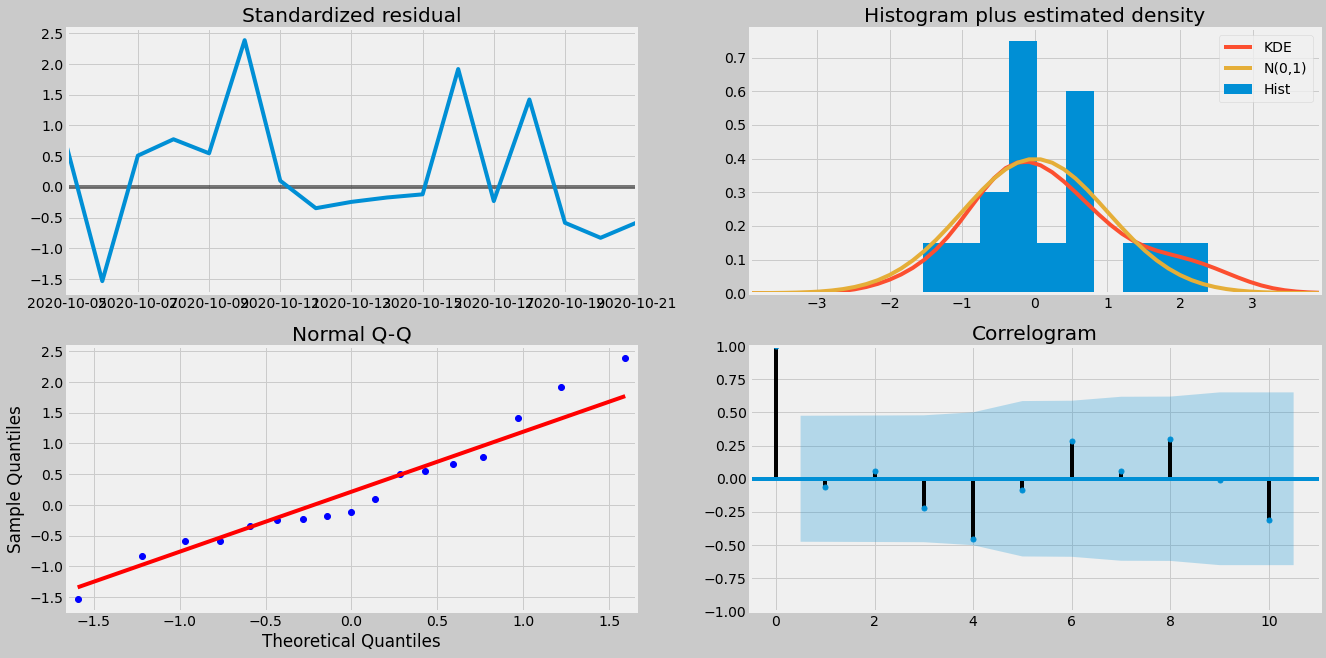

In [68]:
#Plotting the diagnostics.

#The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.
fig=results.plot_diagnostics(figsize=(20,10))
fig.patch.set_facecolor('#cacacaff')
plt.show()


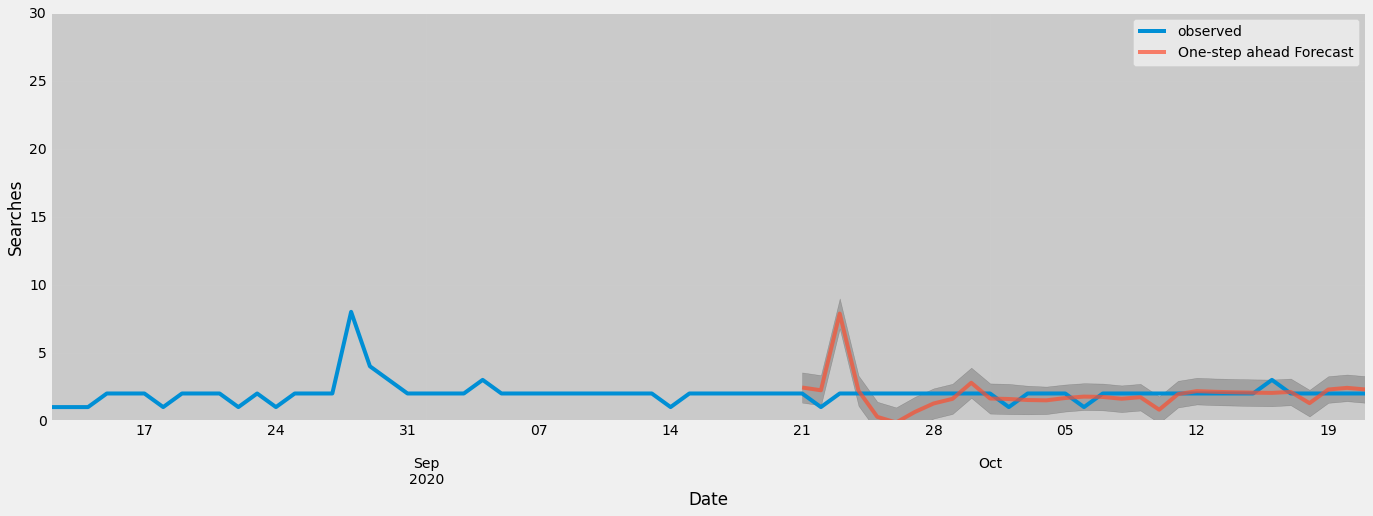

In [69]:
#Lets get the predictions and confidence interval for those predictions.
#Get the predictions. The forecasts start from the 1st of Jan 2017 but the previous line shows how it fits to the data.
pred = results.get_prediction(start=pd.to_datetime('2020-09-21'), dynamic=False) #false is when using the entire history.
#Confidence interval.
pred_ci = pred.conf_int(0)

#Plotting real and forecasted values.
ax = series.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(21, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date',color='black')
ax.set_ylabel('Searches',color='black')
ax.patch.set_facecolor('#cacacaff')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

ax.set_ylim(0,30)  # ajust y axis range for numeric input
#ax.set_yticks(np.arange(0, 110 + 1, 10))  # adjust the y tick frequency
ax.legend(bbox_to_anchor=(0.99, 12)) #customise the legend location
plt.legend()
plt.show()

#Takeaway: The forecats seems to be fitting well to the data. The Blue/purple thicker plot shows the confidence level in the forecasts. 

In [70]:
#Getting the mean squared error (average error of forecasts).
y_forecasted = pred.predicted_mean
y_truth = series['2020-09-22':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('MSE {}'.format(round(mse, 2)))

#Smaller the better.

MSE 1.73


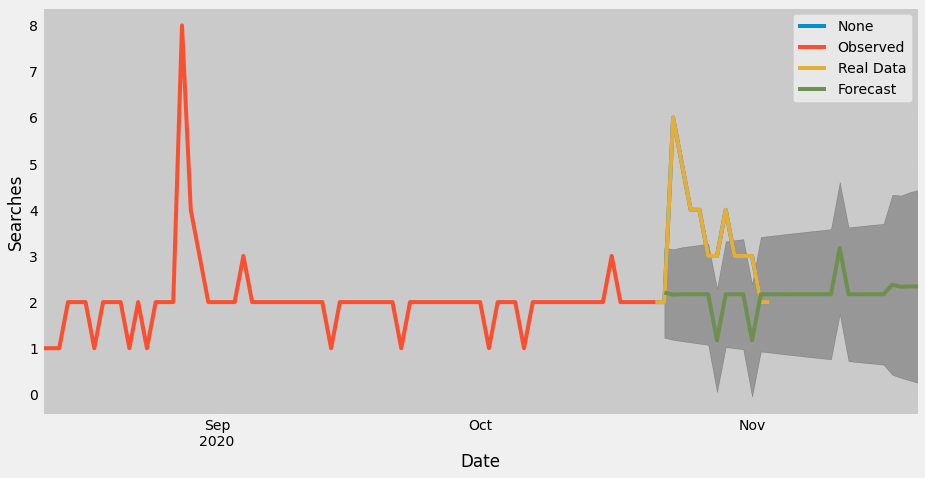

In [71]:
timeframe='2020-10-21 2020-11-09'
pytrend.build_payload(kw_list, timeframe=timeframe, geo='US', gprop='youtube')
trends_test = pytrend.interest_over_time()
trends_test= trends_test.set_index(pd.to_datetime(trends_test.index))
series_test = pd.Series(trends_test['dolla'].values, index = trends_test.index)

ax1=series_test.plot()

#The time can be changed using steps.
pred_uc = results.get_forecast(steps=30)
pred_ci = pred_uc.conf_int(95)
ax = series.plot(label='Observed', figsize=(14, 7))
ax1=series_test.plot(label='Real Data')
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date',color='black')
ax.set_ylabel('Searches',color='black')
ax.patch.set_facecolor('#cacacaff')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

#ax.set_ylim(0,110)  # ajust y axis range for numeric input
#ax.set_yticks(np.arange(0, 110 + 1, 10))  # adjust the y tick frequency
ax.legend(bbox_to_anchor=(0.99, 12)) #customise the legend location
plt.legend()
plt.show()




# Hourly data on same features

**timeframe**

Date to start from

Defaults to last 5yrs, 'today 5-y'.

Everything 'all'

Specific dates, 'YYYY-MM-DD YYYY-MM-DD' example '2016-12-14 2017-01-25'

Specific datetimes, 'YYYY-MM-DDTHH YYYY-MM-DDTHH' example '2017-02-06T10 2017-02-12T07'

Note Time component is based off UTC
Current Time Minus Time Pattern:

By Month: 'today #-m' where # is the number of months from that date to pull data for

For example: 'today 3-m' would get data from today to 3months ago
NOTE Google uses UTC date as 'today'
Seems to only work for 1, 2, 3 months only
Daily: 'now #-d' where # is the number of days from that date to pull data for

For example: 'now 7-d' would get data from the last week
Seems to only work for 1, 7 days only
Hourly: 'now #-H' where # is the number of hours from that date to pull data for

For example: 'now 1-H' would get data from the last hour
Seems to only work for 1, 4 hours only

**kw_list**

keywords to get data for

Example ['Pizza']

Up to five terms in a list: ['Pizza', 'Italian', 'Spaghetti', 'Breadsticks', 'Sausage']

Advanced Keywords

When using Google Trends dashboard Google may provide suggested narrowed search terms.
For example "iron" will have a drop down of "Iron Chemical Element, Iron Cross, Iron Man, etc".
Find the encoded topic by using the get_suggestions() function and choose the most relevant one for you.
For example: https://www.google.com/trends/explore#q=%2Fm%2F025rw19&cmpt=q
"%2Fm%2F025rw19" is the topic "Iron Chemical Element" to use this with pytrends
You can also use pytrends.suggestions() to automate this.

**gprop**

What Google property to filter to
Example 'images'
Defaults to web searches
Can be images, news, youtube or froogle (for Google Shopping results)

Below is the format for building payloads for the pytrends API

```
#kw_list = ["Blockchain"]
pytrends.build_payload(kw_list, cat=0, timeframe='today 5-y', geo='', gprop='')
```



In [72]:
kw_list = df_tags['tags'].head(5).values.tolist()
print(kw_list)


['video', '2020', 'music', 'new', 'nba']


In [73]:

def newtrend(kw_list,timeframe):
  ax=trends.plot()
  plt.legend()
  plt.show()


HTTPSConnectionPool(host='trends.google.com', port=443): Read timed out. (read timeout=5)


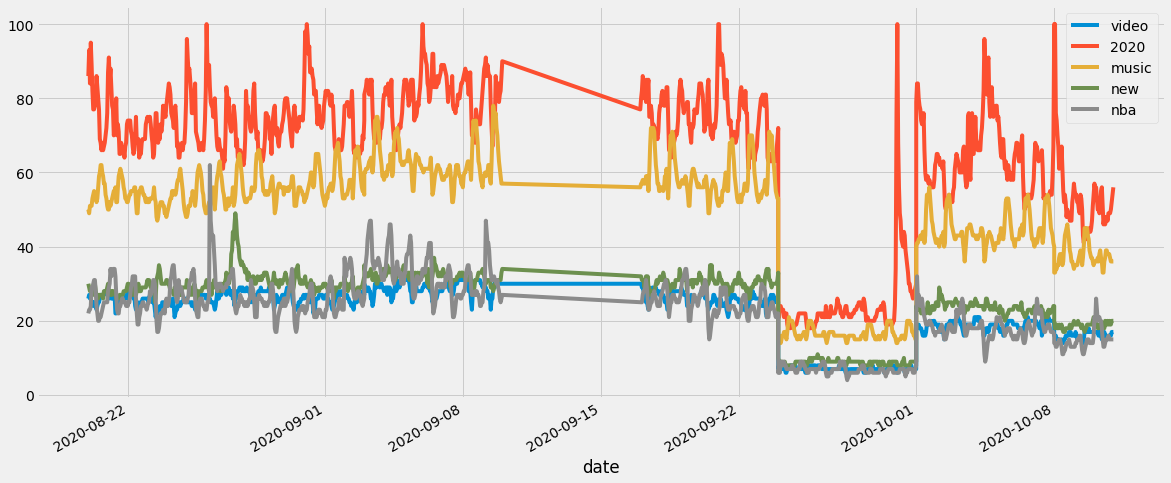

In [74]:
kw_list = df_tags['tags'].head(5).values.tolist()
timeframe='2020-08-12 2020-10-21'
trends = pytrend.get_historical_interest(kw_list, year_start=2020, month_start=8, day_start=20, hour_start=0, year_end=2020, month_end=10, day_end=11, hour_end=0, geo='US', gprop='youtube')
newtrend(kw_list,timeframe)

ax.set_xlabel('Date',color='black')
ax.set_ylabel('Searches',color='black')
ax.patch.set_facecolor('#cacacaff')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
ax.set_ylim(0,110)  # ajust y axis range fo r numeric input
ax.set_yticks(np.arange(0, 110 + 1, 10))  # adjust the y tick frequency
ax.legend(bbox_to_anchor=(0.99, 12)) #customise the legend location

HTTPSConnectionPool(host='trends.google.com', port=443): Read timed out. (read timeout=5)


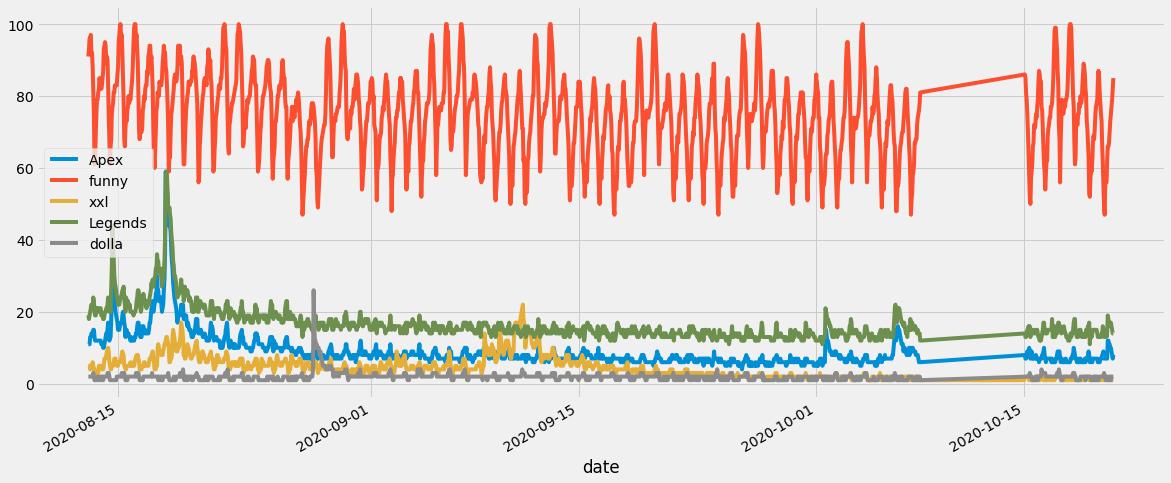

In [75]:
kw_list = ['Apex','funny', 'xxl', 'Legends','dolla']
timeframe='2020-08-12 2020-10-21'
trends = pytrend.get_historical_interest(kw_list, year_start=2020, month_start=8, day_start=13, hour_start=0, year_end=2020, month_end=10, day_end=21, hour_end=0, geo='US', gprop='youtube')
newtrend(kw_list , timeframe)

ax.set_xlabel('Date',color='black')
ax.set_ylabel('Searches',color='black')
ax.patch.set_facecolor('#cacacaff')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
ax.set_ylim(0,110)  # ajust y axis range fo r numeric input
ax.set_yticks(np.arange(0, 110 + 1, 10))  # adjust the y tick frequency
ax.legend(bbox_to_anchor=(0.99, 12)) #customise the legend location

In [76]:
series = pd.Series(trends['Apex'].values, index = trends.index)


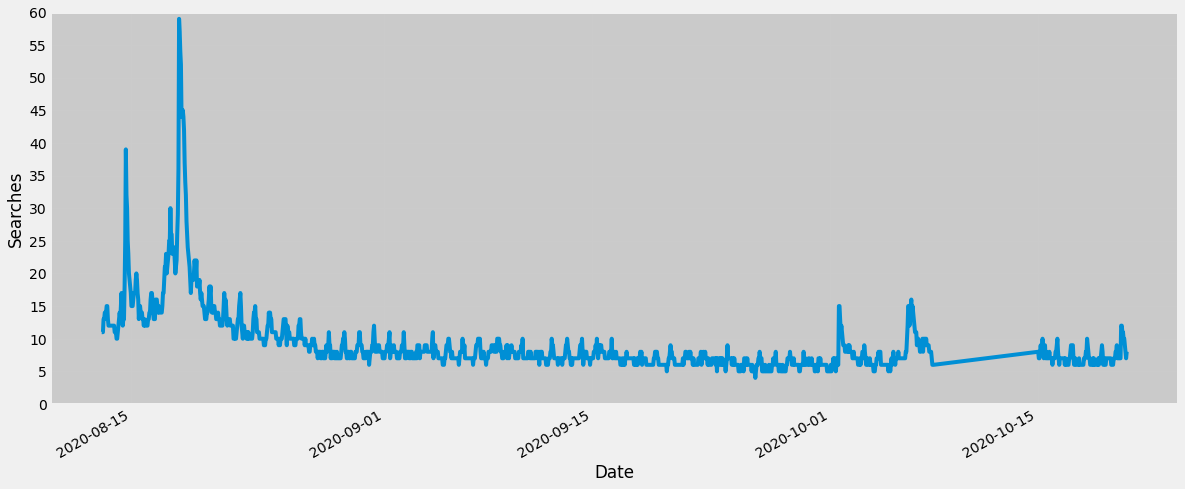

In [77]:
ax=series.plot()
ax.set_xlabel('Date',color='black')
ax.set_ylabel('Searches',color='black')
ax.patch.set_facecolor('#cacacaff')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
ax.set_ylim(0,60)  # ajust y axis range fo r numeric input
ax.set_yticks(np.arange(0, 60 + 1, 5))  # adjust the y tick frequency
plt.show()

In [78]:
#Splitting according to the above description
train1, test1 = trends.iloc[:20, 0], trends.iloc[20:37, 0]
train2, test2 = trends.iloc[:37, 0], trends.iloc[37:54, 0]
train3, test3 = trends.iloc[:54, 0], trends.iloc[54:71, 0]

In [79]:
print(train1)

date
2020-08-13 00:00:00    11
2020-08-13 01:00:00    11
2020-08-13 02:00:00    11
2020-08-13 03:00:00    13
2020-08-13 04:00:00    13
2020-08-13 05:00:00    14
2020-08-13 06:00:00    14
2020-08-13 07:00:00    14
2020-08-13 08:00:00    15
2020-08-13 09:00:00    15
2020-08-13 10:00:00    13
2020-08-13 11:00:00    12
2020-08-13 12:00:00    12
2020-08-13 13:00:00    12
2020-08-13 14:00:00    12
2020-08-13 15:00:00    12
2020-08-13 16:00:00    12
2020-08-13 17:00:00    12
2020-08-13 18:00:00    12
2020-08-13 19:00:00    12
Name: Apex, dtype: int64


In [80]:


#First fold RMSE
model1 = ExponentialSmoothing(train1, seasonal='mul', seasonal_periods=12).fit()
pred1 = model1.predict(start=test1.index[0], end=test1.index[-1])
RMSE1=round(sqrt(mean_squared_error(test1, pred1)),2)

#Second fold RMSE
model2 = ExponentialSmoothing(train2, seasonal='mul', seasonal_periods=12).fit()
pred2 = model2.predict(start=test2.index[0], end=test2.index[-1])
RMSE2=round(sqrt(mean_squared_error(test2, pred2)),2)

#Third fold RMSE
model3 = ExponentialSmoothing(train3, seasonal='mul', seasonal_periods=12).fit()
pred3 = model3.predict(start=test3.index[0], end=test3.index[-1])
RMSE3=round(sqrt(mean_squared_error(test3, pred3)),2)

print ("RMSE1:", RMSE1)
print ("RMSE2:", RMSE2)
print ("RMSE3:", RMSE3)

Overall_RMSE=round((RMSE1+RMSE2+RMSE3)/3,2)
print ("Overall RMSE:", Overall_RMSE) 

RMSE1: 2.0
RMSE2: 9.5
RMSE3: 2.99
Overall RMSE: 4.83


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


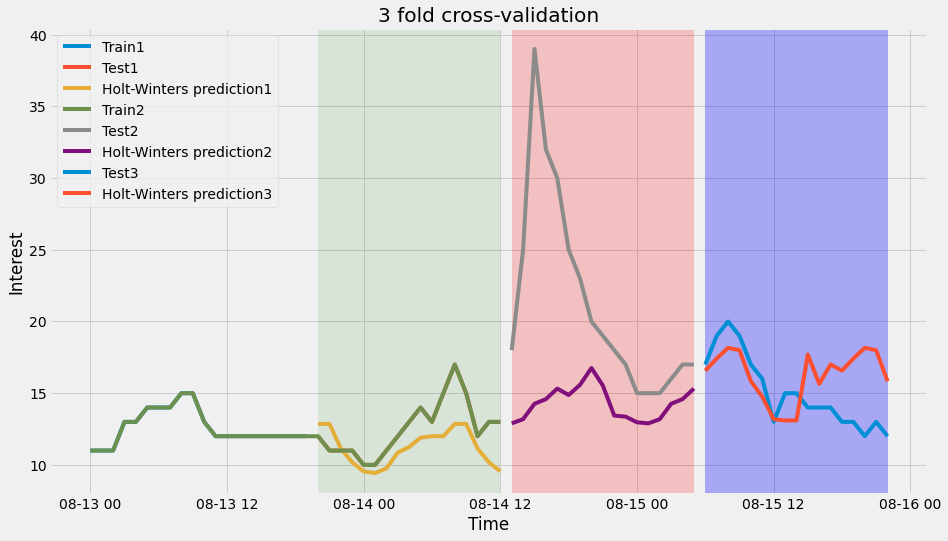

In [81]:
#Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
%matplotlib inline
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 14,8

#Labels and titles
plt.xlabel("Time")
plt.ylabel("Interest")
plt.title("3 fold cross-validation")

#First fold- CV
plt.plot(train1.index, train1, label='Train1')
plt.plot(test1.index, test1, label='Test1')
plt.plot(pred1.index, pred1, label='Holt-Winters prediction1')
plt.legend(loc='best')
#Highlighting the region
plt.axvspan(test1.index[0], test1.index[-1],  facecolor='g', alpha=0.1)

#Second fold
plt.plot(train2.index, train2, label='Train2')
plt.plot(test2.index, test2, label='Test2')
plt.plot(pred2.index, pred2, label='Holt-Winters prediction2')
plt.legend(loc='best')
#Highlighting the region
plt.axvspan(test2.index[0], test2.index[-1],  facecolor='r', alpha=0.2)

#Third fold
plt.plot(test3.index, test3, label='Test3')
plt.plot(pred3.index, pred3, label='Holt-Winters prediction3')
plt.legend(loc='best')
#Highlighting the region
plt.axvspan(test3.index[0], test3.index[-1],  facecolor='b', alpha=0.3)


In [89]:
series = series.resample('4h').mean()


In [ ]:
# Check any number of columns with NaN
print(df.isnull().any().sum(), ' / ', len(df.columns))
# Check any number of data points with NaN
print(df.isnull().any(axis=1).sum(), ' / ', len(df))

In [91]:
#The best part about time series data and decomposition is that you can break down the data into the following:
#Time Series Decomposition. 
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(series, model='additive')
fig = decomposition.plot()
fig.patch.set_facecolor('#cacacaff')
plt.show()



ValueError: ignored

In [92]:
#GRID SEARCH for Param Tuning.
#Sample params for seasonal arima. (SARIMAX).

#For each combination of parameters, we fit a new seasonal ARIMA model with the SARIMAX() function 
#from the statsmodels module and assess its overall quality.

import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 26) for x in list(itertools.product(p, d, q))]

In [93]:

#The code tests the given params using sarimax and outputs the AIC scores.

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(series_stat,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{}26 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [94]:
#Fit the model with the best params.
#SARIMA(1, 0, 1)x(0, 1, 1, 26)26 - AIC:5241.865815138534

#we should consider this to be optimal option.

from statsmodels.tsa.statespace.sarimax import SARIMAX
mod = sm.tsa.statespace.SARIMAX(series,
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 26),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9008      0.024     37.761      0.000       0.854       0.948
ma.L1          0.1241      0.058      2.149      0.032       0.011       0.237
ma.S.L26      -1.3698      0.047    -29.358      0.000      -1.461      -1.278
sigma2         1.2815      0.062     20.838      0.000       1.161       1.402


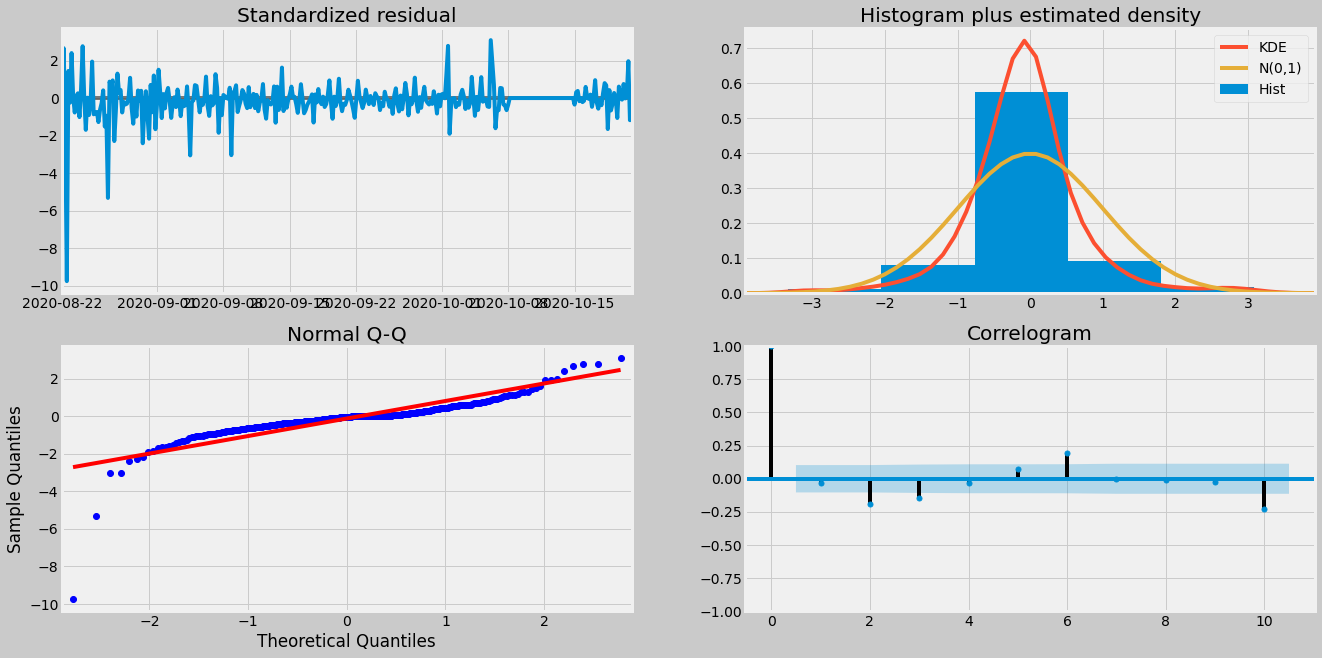

In [95]:
#Plotting the diagnostics.

#The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.
fig=results.plot_diagnostics(figsize=(20,10))
fig.patch.set_facecolor('#cacacaff')
plt.show()


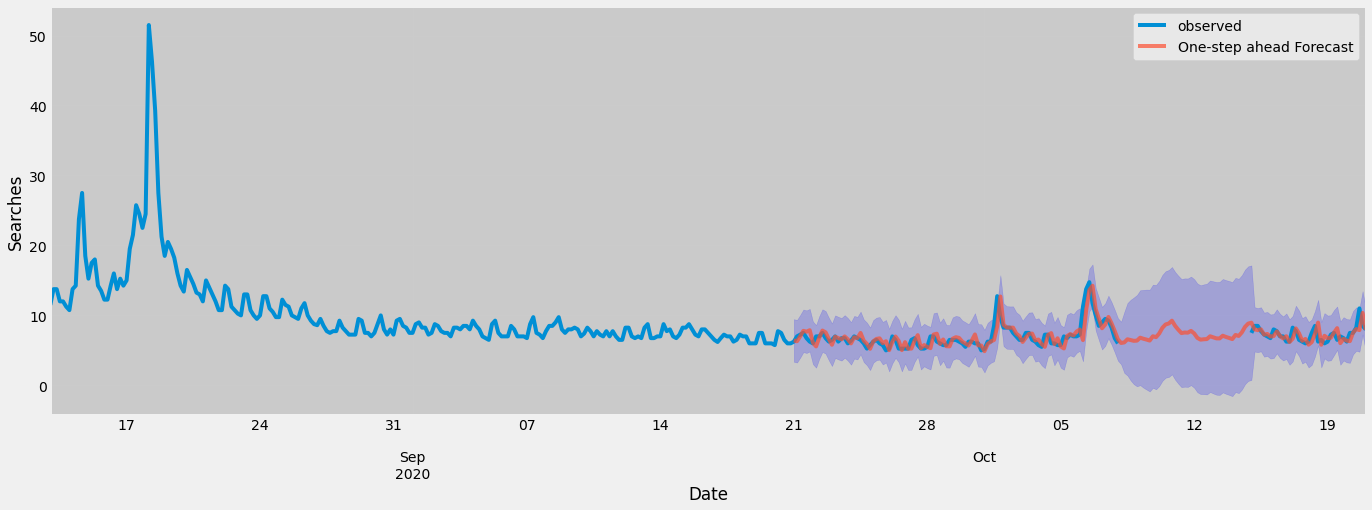

In [96]:
#Lets get the predictions and confidence interval for those predictions.
#Get the predictions. The forecasts start from the 1st of Jan 2017 but the previous line shows how it fits to the data.
pred = results.get_prediction(start=pd.to_datetime('2020-09-21'), dynamic=False) #false is when using the entire history.
#Confidence interval.
pred_ci = pred.conf_int(95)

#Plotting real and forecasted values.
ax = series.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(21, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='blue', alpha=.2)
ax.set_xlabel('Date',color='black')
ax.set_ylabel('Searches',color='black')
ax.patch.set_facecolor('#cacacaff')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

#ax.set_ylim(0,100)  # ajust y axis range for numeric input
#ax.set_yticks(np.arange(0, 40 + 1, 5))  # adjust the y tick frequency
ax.legend(bbox_to_anchor=(0.99, 12)) #customise the legend location
plt.legend()
plt.show()

#Takeaway: The forecats seems to be fitting well to the data. The Blue/purple thicker plot shows the confidence level in the forecasts. 

In [97]:
#Getting the mean squared error (average error of forecasts).
y_forecasted = pred.predicted_mean
y_truth = series['2020-09-22':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('MSE {}'.format(round(mse, 2)))

#Smaller the better.

MSE 1.15


The request failed: Google returned a response with code 500.


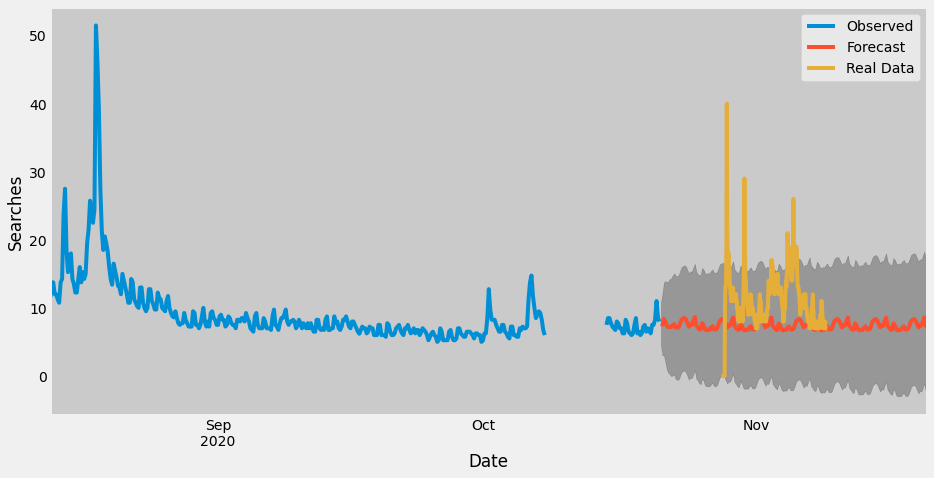

In [104]:


kw_list = ['Apex','funny', 'xxl', 'Legends','dolla']
trends_test = pytrend.get_historical_interest(kw_list, year_start=2020, month_start=10, day_start=21, hour_start=0, year_end=2020, month_end=11, day_end=9, hour_end=0, geo='US', gprop='youtube')
trends_test= trends_test.set_index(pd.to_datetime(trends_test.index))
series_test = pd.Series(trends_test['Apex'].values, index = trends_test.index)

#The time can be changed using steps.
pred_uc = results.get_forecast(steps=182)
pred_ci = pred_uc.conf_int(95)
ax = series.plot(label='Observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax1=series_test.plot(label='Real Data')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date',color='black')
ax.set_ylabel('Searches',color='black')
ax.patch.set_facecolor('#cacacaff')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

#ax.set_ylim(0,40)  # ajust y axis range for numeric input
#ax.set_yticks(np.arange(0, 40 + 1, 5))  # adjust the y tick frequency
ax.legend(bbox_to_anchor=(0.99, 12)) #customise the legend location
plt.legend()
plt.show()
